<a href="https://colab.research.google.com/github/temporiIlustribus/NeuroMice/blob/master/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import pandas as pd
import bisect as bs

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import quantile_transform


import math
import random

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Фрагмент кода взятый из ноутбука Роберта - данные о траектории мыши: в столбце 1 - время, далее координаты x и y.


In [5]:
track = pd.read_csv('/content/drive/My Drive/NVista Calcium Imaging Data/CA1_6_1D_NB_track.csv')
track.columns = ['time', 'x', 'y']
track = track.set_index('time')
track.index = (track.index * 20).astype(np.int32)

Временные ряды активности клеток (нейроданные), в 1-м столбце время, в остальных - активность каждой из клеток, упорядочекнных в соответствии с номерами в папках filters

In [6]:
neuropil = pd.read_csv('/content/drive/My Drive/NVista Calcium Imaging Data/CA1_6_1day_conc_recording_20161116_121433_corrected_neuropil_30.csv')
neuropil.columns = list(range(len(neuropil.columns)))
neuropil = neuropil.set_index(0)
neuropil.index = (neuropil.index * 20).astype(np.int32)

Джоин данных активности и координат

In [7]:
print(neuropil)
full_data = neuropil.iloc[645:].reset_index(drop=True).join(track, how='inner').loc[10:]

           1         2         3    ...       588       589       590
1     0.000332  0.000696 -0.007244  ...  0.003143 -0.000281 -0.003166
2    -0.000171 -0.000175 -0.006733  ...  0.004632 -0.000615 -0.004549
3     0.000850  0.001141 -0.004034  ...  0.003622 -0.000263 -0.003942
4     0.001204  0.001177 -0.004752  ...  0.003133 -0.000666 -0.003830
5     0.000338  0.000619 -0.003601  ...  0.003742 -0.000682 -0.004852
...        ...       ...       ...  ...       ...       ...       ...
6766  0.000703 -0.004620 -0.003373  ... -0.007845 -0.001260  0.001340
6767  0.001013 -0.002834 -0.001902  ... -0.005478 -0.001772  0.002372
6768 -0.000285 -0.003092 -0.000582  ... -0.006764 -0.001007 -0.000095
6769 -0.001154 -0.003235 -0.002139  ... -0.005752 -0.000661  0.000772
6770 -0.000015 -0.003267 -0.003478  ... -0.008398  0.000138  0.000041

[6770 rows x 590 columns]


In [8]:
full_data

1         2         3  ...       590          x          y
10   -0.004962 -0.007518  0.002856  ... -0.003236 -19.161957   5.008783
11   -0.005094 -0.005817  0.003220  ... -0.000709 -20.055400   5.602721
12   -0.004959 -0.007381  0.002250  ... -0.001314 -19.999324   6.323581
13   -0.004731 -0.006127  0.002409  ... -0.004089 -19.921652   7.028567
14   -0.005890 -0.007438  0.003455  ... -0.002331 -19.838119   7.727636
...        ...       ...       ...  ...       ...        ...        ...
6120  0.000703 -0.004620 -0.003373  ...  0.001340  -1.945604  27.854219
6121  0.001013 -0.002834 -0.001902  ...  0.002372  -2.583941  27.618590
6122 -0.000285 -0.003092 -0.000582  ... -0.000095  -3.243736  27.372538
6123 -0.001154 -0.003235 -0.002139  ...  0.000772  -3.973144  27.050267
6124 -0.000015 -0.003267 -0.003478  ...  0.000041  -4.702011  26.713348

[6115 rows x 592 columns]

Далее идет выбор хороших нейронов, взятый из ноутбука роберта


In [9]:
fine_cells = pd.read_csv('/content/drive/My Drive/NVista Calcium Imaging Data/CA1_6_1D_NB_fine_cells.csv')
fine_cells['time'] = fine_cells['time,s\cell#']
fine_cells.drop(['time,s\cell#'], axis=1, inplace=True)
fine_cells.set_index('time', inplace=True)
fine_cells.index = (fine_cells.index * 20).astype(np.int32)

In [10]:
def get_y(y, n=10):
    return ((np.angle((y.x + 1j * y.y).values) + np.pi) / 2 / np.pi * 10).astype(int)

In [11]:
best_columns = fine_cells.columns.astype(int)

X_cols = full_data.columns[:-2]
y_cols = full_data.columns[-2:]
X = full_data[X_cols]
y = get_y(full_data[y_cols])
mis = dict()

for col in X.columns:
    quantiles = [X[col].quantile(q) for q in np.arange(0, 1, 0.1)]
    batches = np.zeros(len(y)).astype(int)
    for q in quantiles:
        batches += (X[col] - q >= 0)
    mis[col] = mutual_info_score(batches, y)

In [12]:
cols = [col for col, _ in sorted(mis.items(), key=lambda x: -x[1])][:250]

In [13]:
best_columns = best_columns.to_list()
print(best_columns)

[4, 69, 92, 116, 123, 128, 136, 143, 147, 153, 161, 165, 170, 176, 188, 192, 208, 231, 273, 354, 408, 543, 570, 577]


In [14]:
sorted_good_cols = cols

Важно:
Значения квантиля активации

In [15]:
activation_quantile = 0.86
break_angle = 0.07

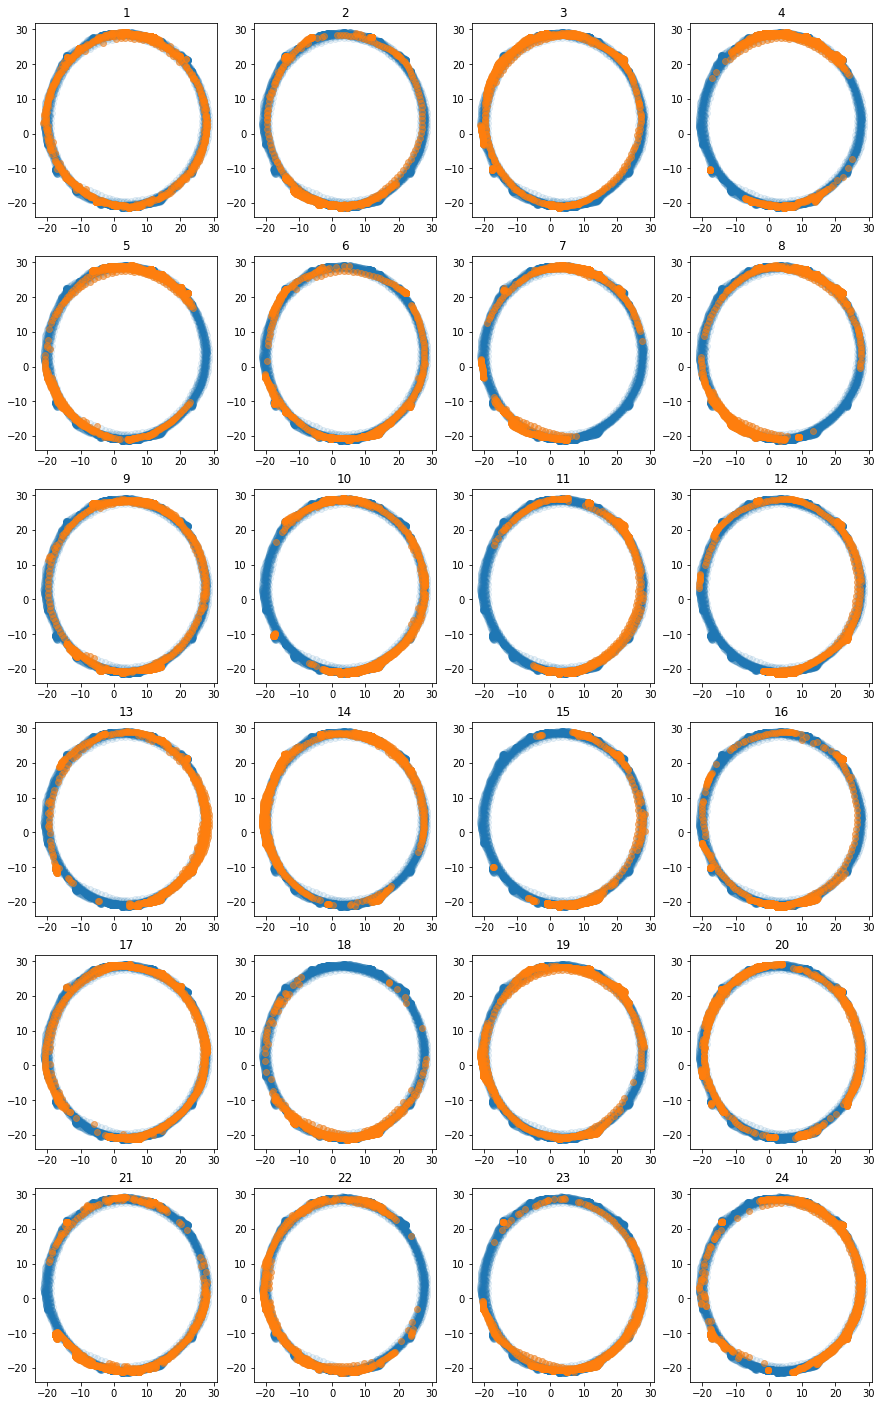

In [16]:
new_data = full_data
quantiles = new_data.quantile(activation_quantile)
cols = new_data.columns[:24].astype(int)

plt.figure(figsize=(15, 25))

for i, col in enumerate(cols):
  plt.subplot(6, 4, i + 1)
  plt.title(col)

  active_state = (new_data[col] > quantiles[col]).values
  plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
  plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)

Ниже идут различные utility ф-ции

In [17]:
def dist(a, b):
  x1, y1 = a
  x2, y2 = b
  return math.hypot((x1-x2),(y1-y2))


def calc_density(data, p):
  dty = []
  for i, row in data.iterrows():
    p1 = (row['x'], row['y'])
    dty.append(1 / max(dist(p,p1) ** 2, 0.000001))
  return np.sum(dty)

def convert_to_angle(point):
  x = float(point['x'])
  y = float(point['y'])
  angle = 0
  if (x > 0 and y >= 0):
    angle = math.atan(y/x)
  elif (x > 0 and y < 0):
    angle = math.atan(y/x) + 2 * math.pi
  elif (x < 0):
    angle = math.atan(y/x) + math.pi
  else:
    if (y > 0):
      angle = math.pi/2
    elif (y < 0):
      angle = 3*math.pi/2
  return angle

def norm_angle(a):
  if (a > 2 * math.pi):
    a -= 2 * math.pi * math.floor(a / (2 * math.pi))
  if (a < 0):
    a += 2 * math.pi * math.ceil(abs(a) / (2 * math.pi))
  return a

def angle_dist(a,b):
  a = norm_angle(a)
  b = norm_angle(b)
  res = norm_angle(max(a,b) - min(a,b));
  if (res > math.pi):
    res -= 2 * math.pi
  return abs(res)
# for our problem r = 25, off_x = 3, off_y = 3
def convert_from_angle(a, r = 25, offset_x = 3, offset_y = 3):
  return (r * math.cos(a) + offset_x, r * math.sin(a) + offset_y)

def make_arc_std(arc):
  f = 1
  s = 0
  if (len(arc) == 3):
    f = 0
    s = 2 
  while (arc[s] > 2 * math.pi):
    arc[s] -= 2 * math.pi
  while (arc[f] > 2 * math.pi):
    arc[f] -= 2 * math.pi
  if (arc[f] < arc[s]):
    arc[f] = 2 * math.pi + arc[f]
  return (arc[s], arc[f])


def get_arc_ends(arc):
  return (arc[0], arc[2])

# Revised multi-modal algo utilities

def get_modal_vals(angles, radius=3.5):
  aprx_angles = angles.apply(lambda x: math.floor(x * radius) / radius)
  hist = dict()
  for angle in aprx_angles:
    if angle not in hist.keys():
      hist[angle] = 1
    else:
      hist[angle] += 1
  aprx_angles = sorted(aprx_angles, key = lambda ang: hist[ang])
  return aprx_angles[ : max(math.floor(len(aprx_angles) / 4), 1)]

# Нахождение Дуг

##Наивный алгоритм

---

Действуем в предположении что шум на данных достаточно небольшой.
На точках $p_i$ круга $C$ задаем ф-цию плотности $density$.

$density(p_x) = \sum_{p \in C; p != p_x} {\frac{1}{\rho(p_x, p)^2}}$

Где $\rho(a,b)$ - евклидово расстояние.

Видно что такая ф-ция плотности для точек, расположенных в "скоплении" точек будет больше чем для точек расположенных далеко от других, что и описывает "плотность".

Для достаточно четко заданных дуг, точки на концах дуг будут иметь самую малую плотность, однако при наличиии нескольких дуг или шума результат оказывается сильно хуже.

Действуя в предположении что имеем лишь одну дугу и что шумом можно пренебречь получаем что концы дуги - точки с наименьшей плотностью.
Такие точки несложно найти. Далее третья точка (необхадимая для однозначного задания дуги) выбирается как средняя точка между концами.

Как показало тестирование - зашумленность данных и наличие нескольких дуг делают данный алгоритм мало пригодным для данной задачи.



In [ ]:
def get_arc_center(data, points):
  avg_x = (points[0][0] + points[2][0])/2
  avg_y = (points[0][1] + points[2][1])/2
  offset = (points[0][0] * points[2][1] + points[2][0] * points[0][1]) / (points[0][0] - points[2][0])
  coef = (points[0][1] - offset)/points[0][0]
  perp_offset = 1/coef * avg_x + avg_y

  # Center is approx (3,3)
  c2 = coef * coef
  r2 = 25**2
  o2 = perp_offset * perp_offset

  D_sqrt = math.sqrt(-c2 * (c2*o2 - 6 * c2 * perp_offset  - c2*r2 + 9*c2 - 6 * coef * perp_offset + 18 * coef - r2 + 9))
  b1 = 3*c2 + coef * perp_offset - 3 * coef;

  x_1 = (b1 + D_sqrt)/(c2 + 1)
  x_2 = (b1 - D_sqrt)/(c2 + 1)
  y_1 = -1/coef * x_1 +perp_offset
  y_2 = -1/coef * x_2 +perp_offset

  avg_point = (np.average(data.x), np.average(data.y))

  if (dist(mean_point, (x_1, y_1)) <= dist(mean_point, (x_2, y_2))):
    return (x_1, y_1)
  return (x_2, y_2)

def get_arc_naive(data):
  points = [None, None, None]
  cur_density = -1
  density = []
  for i, row in data.iterrows():
    p = (row['x'], row['y'])
    density.append(calc_density(data,p))
    if (cur_density < 0) or (density[-1] < cur_density):
      cur_density = density[-1]
      points[0] = p
  j = 0
  cur_density = -1
  for i, row in data.iterrows():
    p = (row['x'], row['y'])
    if (density[j] < cur_density or cur_density < 0) and p != points[0]:
      cur_density = density[-1]
      points[2] = p
    j += 1
  points[1] = get_arc_center(data, points.copy())
  return points

##Продвинутый алгоритм



---

Было решено использовать качественно другой подход. Так как имеем дело с точками окружности - можем однозначно задать все точки в виде углов.

Из результатов наивного алгоритма понятно что использовать медиану и среднее значение не получится из-за шума и наличичя нескольких дуг данные оценки на положение дуг имеют малую точность.

Решено было находить моду по округленным значениям углов каждой из точек (как метод округления использовался $\frac{\lfloor r \phi \rfloor}{r}$ - $\phi$ округляемые к некоторму значению a таким образом лежат в дуге c градусной мерой $\frac{1}{r}$). В таком случае внутри дуг будем иметь места с большой концентрацией точек, именно такие участки и будут модой. В случае если имеем несколько "хорошо" выраженных дуг - будем иметь несколько мод (набор данных будет мультимодален).

Считая что мода соответствует точке дуги будем искать концы данной дуги.
Для дуги нам важно что точки в ней лежат плотно и близко друг к другу, а значит разнциа в углах для каждой из соседних точек должна быть маленькой.

Отстортируем все точки по значению угла. Теперь будем идти по точкам от моды против часовой стрелки пока или не встретим такие две соседние точки что расстояние между ними больше некоторого пределного значения $breakAngle$ или пока ен вернемся в начальную точку. Аналогичным образом будем идти по часовой стрелке. 

Данный алгоритм более стабилен относительно зашумленности данных и позволяет находить наборы дуг (в случае если они все "хорошо" заданны)

In [18]:
def get_mode_angle(angles, radius=10):
  aprx_angles = angles.apply(lambda x: math.floor(x*radius)/radius)
  angle_modes = aprx_angles.mode()
  return angle_modes

def find_arc_end(point_lst, start_angle, break_angle, direction='anti-clockwise', endPoint = None, debug=False):
  i = bs.bisect_right(point_lst, start_angle)
  prev_angle = None
  end = point_lst[i]
  if direction=='anti-clockwise':
    flag = False
    for j in range(i, len(point_lst)):
      if prev_angle != None:
        if (angle_dist(prev_angle, point_lst[j]) >= break_angle or 
            point_lst[j] == endPoint or point_lst[j] == start_angle):
          end = prev_angle
          flag = True
          if (debug):
            print('breaking arc off:', point_lst[j], prev_angle, 'and diff:', angle_dist(prev_angle, point_lst[j]))
          break
      prev_angle = point_lst[j]
    if not flag:
      if (point_lst[-1] > math.pi):
        prev_angle = point_lst[-1] - 2 * math.pi
      else:
        prev_angle = point_lst[-1]
      for j in range(0, i):
        if (angle_dist(prev_angle, point_lst[j]) >= break_angle or 
            point_lst[j] == endPoint or point_lst[j] == start_angle):
          end = prev_angle
          if (debug):
            print('breaking arc off:', point_lst[j], prev_angle, 'and diff:', angle_dist(prev_angle, point_lst[j]))
          break
        prev_angle = point_lst[j]
  elif direction == 'clockwise':
    flag = False
    for j in range(i,-1,-1):
      if prev_angle != None:
        if (angle_dist(prev_angle, point_lst[j]) >= break_angle or 
            point_lst[j] == endPoint):
          end = prev_angle
          flag = True
          if (debug):
            print('breaking arc off:', point_lst[j], prev_angle, 'and diff:', angle_dist(prev_angle, point_lst[j]))
          break
      prev_angle = point_lst[j]
    if not flag:
      if (point_lst[0] > math.pi):
        prev_angle = point_lst[0] - 2 * math.pi
      else:
        prev_angle = point_lst[0]
      for j in range(0, -len(point_lst),-1):
        if (angle_dist(prev_angle, point_lst[j]) >= break_angle or 
            point_lst[j] == endPoint):
          end = prev_angle
          if (debug):
            print('breaking arc off:', point_lst[j], prev_angle, 'and diff:', angle_dist(prev_angle, point_lst[j]))
          break
        prev_angle = point_lst[j]
  return end

def get_arc_sortbased(data, break_angle, debug=False):
  points = data.loc[:,'x':]
  angles = points.apply(convert_to_angle,axis=1)
  points['angles'] = angles
  modes = get_mode_angle(points.loc[:,'angles'],radius=2).tolist()
  if (debug):
    print('MODES')
    print(modes)
  points = points.sort_values(by=['angles'])
  point_lst = points['angles'].tolist()
  arcs = []
  for mode in modes:
    cent = point_lst[bs.bisect_right(point_lst, mode)]
    end_1 = find_arc_end(point_lst, mode, break_angle, debug=debug)
    end_2 = find_arc_end(point_lst, mode, break_angle, direction='clockwise', endPoint=end_1,debug=debug)
    arcs.append([end_1, cent, end_2])
  return arcs

# Improved algo

def get_arc_sortbased_revised(data, break_angle, radius=3.5, debug=False):
  points = data.loc[:,'x':].copy()
  angles = points.apply(convert_to_angle,axis=1)
  points['angles'] = angles
  modes = get_modal_vals(points.loc[:,'angles'],radius=radius)
  if (debug):
    print('MODES')
    print(modes)
  points = points.sort_values(by=['angles'])
  point_lst = points['angles'].tolist()
  arcs = []
  #print(modes)
  for mode in modes:
    cent = point_lst[bs.bisect_right(point_lst, mode)]
    if (len(arcs) > 0):
      for prev in arcs:
        ac_end = prev[0]
        c_end = prev[2]
        arc_flag = False;
        if (ac_end < c_end):
          arc_flag = ((0 <= cent <= ac_end + 0.0001) or (c_end - 0.0001 <= cent <= 2 * math.pi))
        else:
          arc_flag = (c_end - 0.0001 <= cent <= ac_end + 0.0001)
        
        if (arc_flag):
            break
          
      if (arc_flag):
        continue
      
    end_1 = find_arc_end(point_lst, mode, break_angle, debug=debug)
    end_2 = find_arc_end(point_lst, mode, break_angle, direction='clockwise', endPoint=end_1,debug=debug)
    append_flag = False
    for k in range(len(arcs)):
      prev = arcs[k]
      ac_end = prev[0]
      c_end = prev[2]
      if (abs(end_1 - c_end) <= 1.1 * break_angle):
        arcs[k][2] = end_2
        append_flag = True
      if (abs(end_2 - ac_end) <= 1.1 * break_angle):
        arcs[k][0] = end_1
        append_flag = True
      if (append_flag):
        break
    if (append_flag):
      continue
    if (end_1 >= end_2 and end_1 - end_2 >= math.pi/8) or (end_1 < end_2 and (2 * math.pi - end_2) + end_1 >= math.pi/8):
      arcs.append([end_1, cent, end_2])
    #else:
      #print(end_1, end_2)
  return arcs

Посмотрим на работу продвинутого алгоритма для первых 24 нейронов

In [19]:
start_t = 0
end_t = start_t + 24

In [20]:
def snap_to_grid(point, grid_size=0.02):
  x = float(point['x'])
  y = float(point['y'])
  return [grid_size * (x // grid_size), grid_size * (y // grid_size)]

1 [[3.4537618569636646, 3.441002241568417, 3.532602982752906]]
2 [[1.5177503422396728, 3.1443369993819053, 1.6540171087165076]]
3 [[6.01364316595225, 6.01364316595225, 6.041168449213502]]
4 [[2.1284941052960233, 2.018298157994569, 0.6147728819361669], [5.628835734720401, 5.430290317847434, 4.350229663456458]]
5 [[-0.4180709200316919, 5.736321533219219, 4.895530561811527], [2.5531872657257164, 2.2975369502679226, 0.6147728819361669], [4.79568422197849, 4.575583877159566, 2.9791452896388937]]
6 [[2.8349406935349974, 2.5849074228389566, 0.7597113564875777], [0.6406623322239398, 0.007695019744794707, 3.2504136992489125]]
7 [[-1.207499170387469, 3.6222121068336413, 3.6222121068336413], [2.55901221057714, 2.3068318531547005, 0.35998692425445133]]
8 [[2.7193418741602358, 6.266585912010848, 6.266585912010848], [4.97206544666469, 3.0096028230622105, 3.0096028230622105]]
9 [[3.4813502068478734, 3.4813502068478734, 3.542098804062129]]
10 [[2.2301998068071742, 0.8783619049737672, 4.567707109273224

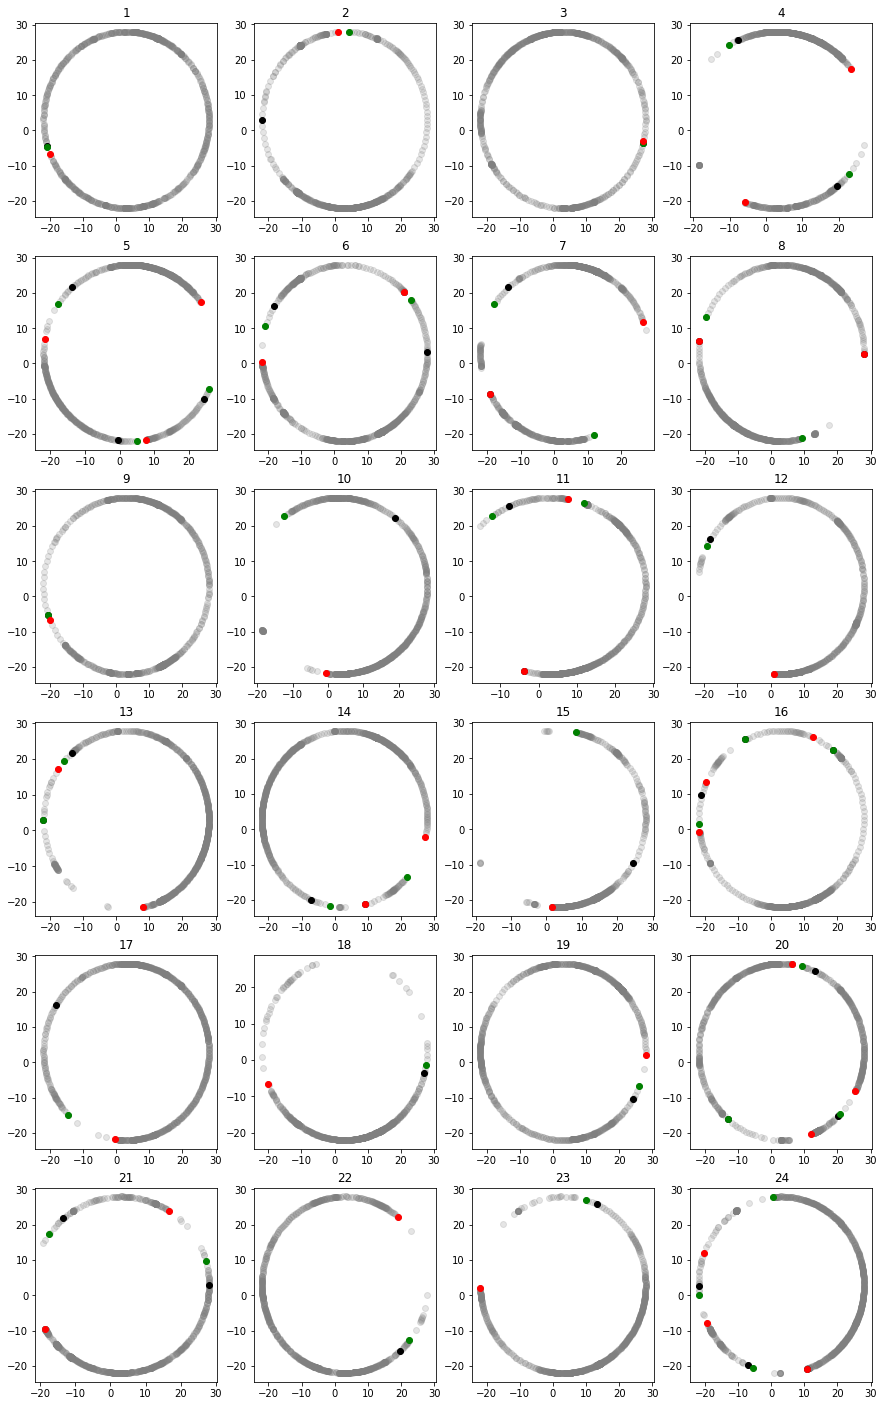

In [21]:
new_data = full_data.copy()
quantiles = new_data.quantile(activation_quantile)
cols = new_data.iloc[:, start_t:end_t].copy().astype(int)

plt.figure(figsize=(15, 25))
neuro_arcs = []
for i, col in enumerate(cols):
  plt.subplot(6, 4, i + 1)
  plt.title(col)
  #plt.scatter(new_data['x'], new_data['y'], c = 'gray', alpha=0.1)
  active_state = (new_data[col] > quantiles[col]).values
  tmp = new_data[active_state].loc[:,'x':].apply(lambda a: pd.Series(snap_to_grid(a, break_angle/5), index=['x', 'y']), axis=1).apply(lambda a: convert_to_angle(a), axis = 1)
  #print(tmp)
  neuro_activ = tmp.apply(lambda a: pd.Series(convert_from_angle(a), index=['x', 'y']))
  #print(neuro_activ)
  plt.scatter(neuro_activ['x'], neuro_activ['y'], c = 'gray', alpha=.2)
  arcs = get_arc_sortbased_revised(new_data[active_state], break_angle, radius=3.5)
  neuro_arcs.append(arcs)
  print(i+1, arcs)
  for arc in arcs:
    x_0, y_0 = convert_from_angle(arc[0], 25, 3, 3)
    x_1, y_1 = convert_from_angle(arc[1], 25, 3, 3)
    x_2, y_2 = convert_from_angle(arc[2], 25, 3, 3)
    plt.scatter(x_1,y_1, c = 'black')
    plt.scatter(x_0,y_0, c = 'green')
    plt.scatter(x_2,y_2, c = 'red')
    
print(len(neuro_arcs))

# Пересечение Дуг



---

Код для нахождения пересечения дуг


In [22]:
def make_seg_std(seg):
  if (seg[1] < seg[0]):
    seg[1] = 2 * pi
  return seg

def get_std_angle(a):
  while (a > 2 * math.pi):
    a -= 2 * math.pi
  if (a < 0):
    a += 2 * math.pi
  return a

def arc_to_segments(arc):
  l, r = get_std_angle(arc[0]), get_std_angle(arc[1])
  if (l > r):
    return ((l, 2 * math.pi), (0, r))
  else:
    return ((l, r), None)

def improved_seg_intersect(s1,s2):
    if (s1 == None or s2 == None):
      return None;
    if (s1[0] > s2[0]):
      s1, s2 = s2, s1
    if s1[1] < s2[0]:
      return None
    else:
      return [s2[0], min(s1[1], s2[1])]

def seg_cmp(a):
  if (a != None):
    return a[0]
  else:
    return 999999

def iterative_seg_union(segs, sort = True, debug = False):
  if (len(segs) == 1):
    return [segs]
  if (sort):
    segs = sorted(segs, key=lambda a: seg_cmp(a))
    if (debug):
      print("Sorted Segments:", segs)
  res = []
  curSeg = segs[0]
  for seg in segs:
    if seg == None:
      if (curSeg != None):
        res.append(curSeg)
        curSeg = None
      continue
    if (curSeg == None):
      curSeg = seg
      continue
    if (curSeg[1] >= seg[0]):
      curSeg[0] = seg[0]
      if (curSeg[1] < seg[1]):
        curSeg[1] = seg[1]
    else:
      res.append(curSeg)
      curSeg = seg
  return res

def arc_intersect(arc1, arc2, debug = False):
  # Standardize arcs
  arc1, arc2 = make_arc_std(arc1), make_arc_std(arc2)

  #Split arcs into segments
  segments = [None, None, None, None]
  segments[0], segments[1] = arc_to_segments(arc1)
  segments[2], segments[3] = arc_to_segments(arc2)
  if (debug):
    print("Segments:", segments)
  res = [None, None, None, None]
  res[0] = improved_seg_intersect(segments[0], segments[2])
  res[1] = improved_seg_intersect(segments[0], segments[3])
  res[2] = improved_seg_intersect(segments[1], segments[2])
  res[3] = improved_seg_intersect(segments[1], segments[3])
  if (debug):
    print("Segments interstions: ", res)
  return iterative_seg_union(res, debug=debug)

# Нахождение набора нейронов места

## Для начала получим дуги, соответствуюшие всем нейронам

In [23]:
active_arcs= []
j = 0
# first get all neuro arcs

new_data = full_data.copy()
quantiles = new_data.quantile(activation_quantile)
cols = new_data.iloc[:, :590].copy(deep=True).astype(int)
neuro_arcs = []
for i, col in enumerate(cols):
  active_state = (new_data[col] > quantiles[col]).values
  arcs = get_arc_sortbased_revised(new_data[active_state], break_angle, radius=3.5)
  neuro_arcs.append(arcs)


## Нормирование данных для калибровки

**Напишем ф-цию счета**

 Для того чтобы уменьшить влияние *неравномерности* входных данных, сначала посмотрим на то, сколько времени мышь проводит в той или иной точке. 
 
 Используя эту информацию, можно нормировать вклад который дает отклонение от требуемого результата в ф-ции счета, обратно частоте для данной позиции.

**Почему это нужно? Все очень просто**

Так как мы не можем гарантировать то, что входные данные будут *равномерны* (т.е. мышь будет находиться во всех точках окружности одинаково долго), то максимизация ф-ции счета (иными словами минимизация ошибки нашего алгоритма), будет улучшать предсказание на дугах, где мышь проводит больше времени соразмерно больше. Такая неравномерность приводит к нестабильности решения (резкому изменению дуги при малом смещении мыши) и плохому качеству предсказания в некоторых секторах. 

Посчитаем нормировачные коэффициенты и построим график

In [24]:
def smart_div(a, b):
  if (abs(b) < 0.000001):
    if (abs(a) > 0.000001):
      return 0
    elif (b == 0):
      return 0
    else:
      return 1
  return a / b

def calc_norm_coefficients(full_data, time_period, arc_count = 100, debug=False):
  arc_count *= 1 / (2 * math.pi)
  points = [a * 1/arc_count for a in list(range(math.floor(2 * math.pi * arc_count)))]
  arc_occurances = {point : 0 for point in points}
  for i, row in full_data.iterrows():
    if i < time_period[0]:
      continue
    elif i > time_period[1]:
      break
    # Calculate number of frames, that the subject is in a given arc
    pos = norm_angle(convert_to_angle(row))
    pos = math.floor(pos * arc_count)/arc_count
    if (pos in points):
      arc_occurances[pos] += 1
    else:
      print("WTF")
  if debug:
    plt.figure(figsize=(10, 10))
    point_colors = [arc_occurances[point] for point in points]
    print(point_colors)
    cur_point = 0
    coord_X = []
    coord_Y = []
    colors = list() # Flying high ofcourse!
    while (cur_point < 2 * math.pi):
      x, y = convert_from_angle(cur_point, 25, 3, 3)
      coord_X.append(x)
      coord_Y.append(y)
      colors.append(math.log10(arc_occurances[math.floor(cur_point * arc_count)/arc_count] + 1))
      cur_point += 0.01
    plt.scatter(coord_X, coord_Y, c=colors, cmap='plasma')
    plt.colorbar()
    plt.show()
  max_val = max(arc_occurances.values())
  res ={point : smart_div(1, arc_occurances[point]) for point in points}
  if (debug):
    plt.figure(figsize=(10, 10))
    point_colors = [res[point] for point in points]
    cur_point = 0
    coord_X = []
    coord_Y = []
    colors = list() # Flying high ofcourse!
    while (cur_point < 2 * math.pi):
      x, y = convert_from_angle(cur_point, 25, 3, 3)
      coord_X.append(x)
      coord_Y.append(y)
      colors.append((res[math.floor(cur_point * arc_count)/arc_count]))
      cur_point += 0.01
    plt.scatter(coord_X, coord_Y, c=colors)
    plt.colorbar()
    plt.show()
  return res

def get_norm_coef(pos, norm_coef):
  a = (1/(2 * math.pi)) * len(norm_coef)
  return norm_coef[math.floor(pos * a)/a]

[30, 31, 36, 31, 30, 28, 30, 29, 32, 37, 57, 38, 103, 100, 42, 44, 53, 72, 157, 62, 51, 49, 78, 63, 52, 93, 164, 74, 73, 45, 42, 59, 35, 69, 138, 44, 34, 32, 32, 33, 25, 30, 27, 25, 26, 32, 23, 24, 30, 29, 30, 28, 38, 23, 23, 24, 24, 24, 83, 45, 25, 58, 47, 29, 33, 96, 33, 38, 63, 77, 60, 69, 64, 97, 445, 255, 144, 90, 236, 91, 107, 103, 151, 64, 63, 57, 39, 37, 37, 34, 30, 31, 46, 40, 31, 30, 34, 32, 28, 32]


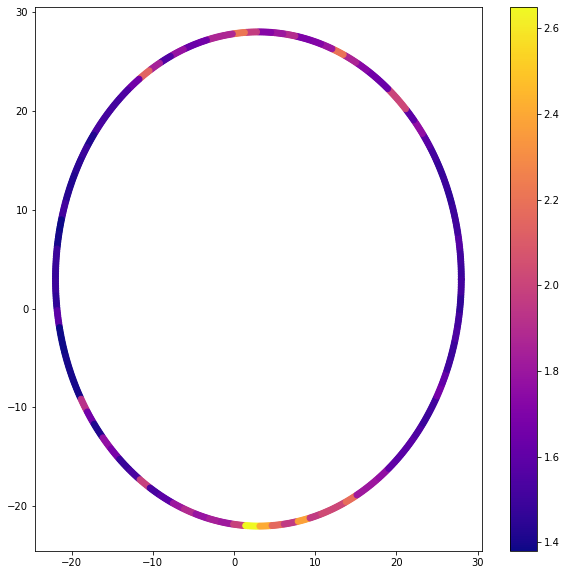

In [25]:
res = calc_norm_coefficients(full_data, [10,6000], arc_count = 100, debug=True)

In [28]:
def convert_to_tuples(data):
  new_data = []
  for el in data:
    new_data.append(tuple(el))
  return new_data

def convert_to_ll(data):
    new_data = []
    for el in data:
      new_data.append(list(el))
    return new_data

In [29]:
def calc_score_func(full_data, neuro_arcs, time_period, neurons, norm_coef, penalty=-1000, inverse_penalty_rule=False, debug=False):
  res_info = [0, 0, 0, 0] # totalScore, No itersection count, error count

  for i, row in full_data.iterrows():
    active_arcs = []
    active_names = []
    if i < time_period[0]:
      continue
    elif i > time_period[1]:
      break
    # check if at current time stamp neuron j is active
    for j in neurons:
      if (row[j] >= quantiles[j]):
        active_arcs.append(neuro_arcs[j])
        active_names.append(j)
    # now we have all active arcs for that specific time moment
    if (debug):
      print(i, active_names)
    # find the position by getting the intersection of all active arcs
    cur_location_arc = [0, 2 * math.pi - 0.00001]
    res_arcs = set()
    res_arcs.add(tuple(cur_location_arc))
    for arc in active_arcs:
      new_res = []
      if (debug):
        print("Intersecting with arc: ", arc)
      for sub_arc in arc:
        for r_arc in res_arcs:
          #print(r_arc)
          if (debug):
            print("\tWorking with sub_arc: ", sub_arc)
          #print()
          tmp_arcs = arc_intersect(r_arc, sub_arc)
          if (debug):
            print("LINKED RES:", tmp_arcs)
          new_res.extend(tmp_arcs)
      res_arcs = set(convert_to_tuples(new_res))
    res_arcs = convert_to_ll(res_arcs)
    real_pos = norm_angle(convert_to_angle(row))
    if (debug):
      print("CURRENT LOCATION AT TIME STAMP (", i, ") :", res_arcs) 
    if len(res_arcs) == 0:
      res_info[0] += penalty * get_norm_coef(real_pos, norm_coef)
      res_info[1] += 1
      res_info[3] += penalty
    flag = False
    sum_length = 0
    min_dist = 2 * math.pi
    for arc in res_arcs:
      sum_length += abs(arc[1] - arc[0])
      if (arc[0] <=  real_pos <= arc[1]) or (2 * math.pi - real_pos <= 0.0005 and arc[0] <= 0.0005):
        flag = True
      else:
        tmp_dist = min(abs(arc[0] - real_pos), abs(real_pos - arc[1]), abs(2 * math.pi + real_pos - arc[1]), abs(2 * math.pi + arc[0] - real_pos))
        if (tmp_dist < min_dist):
          min_dist = tmp_dist
    if flag:
      res_info[0] += 100 * get_norm_coef(real_pos, norm_coef) * (1/(sum_length) - 1/(2 * math.pi))
      if (sum_length > 2 * math.pi):
        print("WTF!\nArc: ", res_arcs)
    else:
      res_info[0] += penalty * get_norm_coef(real_pos, norm_coef) * (min_dist/(2 * math.pi))
      #print(min_dist)
      res_info[2] += 1
      res_info[3] += penalty * (min_dist/(2 * math.pi))
    if not inverse_penalty_rule:
      continue
    
    for j in neurons:
      arcs = neuro_arcs[j]
      for arc in arcs:
        # if the current point is within neurons ark, although the neuron is not active - add additional penalty
        if row[j] < quantiles[j] and ((arc[0] <=  real_pos <= arc[1]) or (2 * math.pi - real_pos <= 0.0005 and arc[0] <= 0.0005)):
          res_info[0] += penalty * get_norm_coef(real_pos, norm_coef)
  return res_info

## Жадный алгоритм нахождения набора нейронов места

Найдем набор нейронов, для которых не появляется штрафа: иными словами, если эти нейроны активны, то мышь находится в соответствующей им дуге

In [30]:
use_soft_filter=False # Soft filter filters based on score purely (e.g. if the score is positive the neuron is considered)

# If we use a hard filter - use percentage of errors and cases where no solution's found
max_errors = 0.02
max_no_sol = 0.01
avg_dist_value = 0.007
penalty = -1000

In [31]:
pos_neurons = set()
sorted_neurons = []
time_period = [10, 3000]
time_period_len = time_period[1] - time_period[0]
for neuron in sorted_good_cols:
  res = calc_score_func(full_data, neuro_arcs, time_period, [neuron], calc_norm_coefficients(full_data, time_period, 200), penalty, inverse_penalty_rule=False)
  if (use_soft_filter):
    if (res[0] > 0):
      pos_neurons.add(neuron)
  else:
    if (res[1] <= max_no_sol * time_period_len and res[2] <= max_errors * time_period_len and (res[2] == 0 or res[3]/(penalty * res[2]) <= avg_dist_value)):
      tmp_len = len(pos_neurons)
      pos_neurons.add(neuron)
      if (tmp_len < len(pos_neurons)):
        sorted_neurons.append([res[0], neuron])
      print(neuron, res)
sorted_neurons = sorted(sorted_neurons, key=lambda x: -x[0])

120 [87.14033035018137, 0, 1, -0.6215552266934731]
106 [5.234525561058679, 0, 4, -14.732121535925305]
77 [1.5352068619157866, 0, 0, 0]
158 [63.61607595749332, 0, 0, 0]
71 [189.35655784402795, 0, 0, 0]
133 [3.570127000224578, 0, 50, -242.08041265869596]
391 [4.057537420693547, 0, 3, -4.774164892292728]
198 [10.38251778178775, 0, 0, 0]
247 [23.893563341126285, 0, 0, 0]
405 [94.48933589048906, 0, 4, -22.63529421696852]
223 [0.0708979929426625, 0, 0, 0]
567 [8.665555406368728, 0, 8, -25.908675875710614]
557 [6.183395566192134, 0, 3, -8.804105350325186]
172 [1.4821437778277395, 0, 0, 0]
575 [65.50836302165925, 0, 21, -75.59268762689922]
201 [2.231608676199662, 0, 8, -7.90036483041167]
453 [10.194833631847631, 0, 5, -16.142202052695147]
279 [12.447990189308582, 0, 5, -19.601145766924393]
385 [55.224211444519305, 0, 0, 0]
357 [16.170030433685792, 0, 19, -76.03287344925155]
560 [23.378660151734234, 0, 0, 0]
300 [108.02784710120338, 0, 0, 0]
155 [2.7334354353461063, 0, 1, -1.7897120792731593]
4

In [32]:
print(pos_neurons)
tmp = []
for el in sorted_neurons:
  tmp.append(el[1])
sorted_neurons = tmp
print(sorted_neurons)


{385, 2, 4, 133, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 557, 300, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 201, 585, 77, 209, 223, 482, 357, 106, 490, 492, 495, 496, 498, 117, 247, 120, 249, 507, 126}
[578, 585, 71, 495, 7, 490, 393, 117, 300, 405, 120, 498, 4, 575, 158, 209, 409, 385, 5, 68, 247, 482, 560, 126, 357, 279, 194, 198, 453, 142, 567, 271, 492, 557, 106, 293, 519, 420, 391, 249, 133, 496, 155, 201, 2, 440, 77, 172, 403, 507, 145, 223]


In [33]:
print(len(sorted_neurons))

52


In [34]:
def res_info_comp(a, b):
  return a[0] < b[0] or (a[0] == b[0] and (a[2] > b[2] or (a[2] == b[2] and a[1] > b[1])))

Теперь используем жадный алгоритм для нахождения оптимального набора нейронов

In [35]:
all_greedy_basis = []

In [36]:
good_time_frames = [[10, 60], [120, 180], [260, 350], [400, 460], [620, 680], [1000, 1200], [1950, 2010], [2200, 2300], [2800, 3000]]

In [37]:
for time_period in good_time_frames:
  period_sz = time_period[1] - time_period[0]
  basis_neurons = set()
  #basis_neurons = good_neurons.copy()


  norm_coef = calc_norm_coefficients(full_data, time_period,arc_count=200)
  #print(norm_coef)

  prev_best = [-999999999, 999999999, 999999999]
  cur_score = prev_best.copy()
  cur_score[0] += 1
  while prev_best[0] <= cur_score[0]:
    cur_best = [-999999999, 999999999, 999999999]
    cur_neuron = None
    print(basis_neurons)
    for neuron in pos_neurons:
      test_basis = basis_neurons.copy()
      test_basis.add(neuron)
      if test_basis != basis_neurons:
        res = calc_score_func(full_data.iloc[time_period[0]-10:time_period[1]-10+1:,:], neuro_arcs, time_period, test_basis, norm_coef, penalty)
        if res[0] > cur_best[0] and res[2]/period_sz <= 0.015 and (res[2] == 0 or res[3]/(penalty * res[2]) <= avg_dist_value):
          cur_best = res
          cur_neuron = neuron
    if prev_best[0] > cur_best[0] or (prev_best[0] == cur_best[0] and prev_best[2] <= res[2]):
      print("Fail:", cur_best)
      cur_score = prev_best
      break 
    basis_neurons.add(cur_neuron)
    prev_best = cur_score
    cur_score = cur_best
    print(cur_score)
  print("Best: ", cur_score)
  all_greedy_basis.append(basis_neurons.copy())

set()
[200.71710208012678, 0, 0, 0]
{495}
[241.09807101030546, 0, 0, 0]
{126, 495}
[274.68466634078044, 0, 0, 0]
{68, 126, 495}
[304.13065238831126, 0, 0, 0]
{120, 68, 126, 495}
[319.94836568092506, 0, 0, 0]
{68, 271, 495, 120, 126}
[334.6072280221012, 0, 0, 0]
{68, 142, 271, 495, 120, 126}
[342.9522773040888, 0, 0, 0]
{68, 142, 271, 495, 405, 120, 126}
[346.874016338953, 0, 0, 0]
{68, 142, 271, 495, 405, 120, 126, 575}
[348.1174409130284, 0, 0, 0]
{68, 142, 271, 495, 405, 120, 155, 126, 575}
[348.2017284428865, 0, 0, 0]
{68, 440, 142, 271, 495, 405, 120, 155, 126, 575}
[348.2017284428865, 0, 0, 0]
{385, 68, 440, 142, 271, 495, 405, 120, 155, 126, 575}
Fail: [348.2017284428865, 0, 0, 0]
Best:  [348.2017284428865, 0, 0, 0]
set()
[166.41979188588266, 0, 0, 0]
{7}
[314.77956926112734, 0, 0, 0]
{490, 7}
[391.8392216717925, 0, 0, 0]
{393, 490, 7}
[467.8207267595167, 0, 0, 0]
{393, 490, 498, 7}
[529.7669497535186, 0, 0, 0]
{385, 7, 393, 490, 498}
[546.3085073175444, 0, 0, 0]
{385, 7, 393, 49

In [44]:
all_greedy_basis = all_greedy_basis[len(all_greedy_basis) - len(good_time_frames):]
for i in range(len(all_greedy_basis)):
  print(good_time_frames[i], all_greedy_basis[i])

[10, 60] {385, 68, 440, 142, 271, 495, 405, 120, 155, 126, 575}
[120, 180] {385, 2, 7, 391, 393, 142, 155, 223, 293, 357, 490, 106, 492, 560, 498, 567, 249, 575}
[260, 350] {385, 2, 198, 391, 201, 77, 142, 120, 223, 490, 172, 492, 560, 496, 440, 249}
[400, 460] {385, 223, 68, 585, 490, 106, 142, 271, 145, 126, 575}
[620, 680] {385, 578, 68, 5, 71, 7, 393, 271, 409, 158, 357, 492, 498, 567, 440, 126}
[1000, 1200] {385, 2, 4, 133, 7, 393, 271, 145, 405, 409, 155, 158, 300, 557, 172, 560, 567, 440, 578, 453, 71, 585, 77, 209, 223, 482, 357, 106, 490, 498, 117, 120}
[1950, 2010] {385, 578, 2, 5, 7, 391, 519, 77, 271, 209, 279, 409, 158, 223, 172, 560, 496, 498, 120, 249}
[2200, 2300] {385, 2, 4, 5, 453, 7, 519, 585, 142, 145, 209, 405, 155, 247, 120, 158, 223, 106, 300, 498, 117, 567, 440, 249}
[2800, 3000] {385, 2, 194, 68, 453, 198, 7, 393, 585, 145, 209, 403, 405, 279, 155, 120, 223, 482, 293, 106, 172, 560, 117, 247, 440, 507, 126}


In [45]:
u_greedy_neurons = set()
int_greedy_neurons = set(all_greedy_basis[0])
for el in all_greedy_basis:
  u_greedy_neurons |= set(el)
  int_greedy_neurons &= set(el)

print(int_greedy_neurons)
print(u_greedy_neurons)

{385}
{385, 2, 4, 5, 133, 7, 391, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 201, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 507, 126}


In [ ]:
u_greedy_neurons = {385, 2, 4, 5, 133, 519, 391, 393, 10, 7, 142, 271, 405, 279, 409, 155, 158, 31, 39, 300, 172, 557, 560, 567, 440, 62, 575, 578, 68, 453, 198, 71, 585, 201, 77, 209, 82, 211, 223, 482, 357, 234, 490, 106, 492, 495, 496, 498, 117, 120, 249, 507, 126}

In [46]:
print(pos_neurons - u_greedy_neurons)

{420}


In [116]:
good_pos_neurons = pos_neurons - set(sorted_neurons[2*len(sorted_neurons)//3:])
print(good_pos_neurons)
print(good_pos_neurons - basis_neurons)
print(basis_neurons - good_pos_neurons)
print(u_greedy_neurons - {385, 2, 7, 519, 391, 145, 403, 155, 158, 420, 293, 300, 172, 560, 440, 578, 194, 453, 198, 71, 585, 75, 77, 209, 223, 234, 490, 117, 247, 120, 126})

{385, 4, 5, 7, 393, 10, 142, 271, 405, 279, 409, 158, 31, 300, 557, 560, 567, 575, 578, 194, 68, 453, 198, 71, 585, 209, 82, 211, 482, 357, 490, 234, 492, 495, 498, 117, 247, 120, 126}
{4, 393, 10, 142, 405, 31, 300, 557, 567, 575, 194, 68, 453, 198, 71, 585, 82, 482, 357, 490, 234, 492, 495, 117, 247, 126}
{2, 519, 391, 172, 77, 496, 249, 223}
{4, 5, 133, 393, 10, 142, 271, 405, 279, 409, 31, 39, 557, 567, 62, 575, 68, 201, 82, 211, 482, 357, 106, 492, 495, 496, 498, 249}


In [47]:
#improved_basis = basis_neurons.copy()
improved_basis = u_greedy_neurons.copy()

In [50]:
# select sqrt(n) items and add new ones selected randomly
possible_arcs = set(pos_neurons) - improved_basis
#possible_arcs = set(sorted_good_cols) - improved_basis

penalty = -1500
n = len(basis_neurons)
sz = math.floor(math.sqrt(n))

#improved_basis = basis_neurons.copy()
iteration_count = 50
time_period = [10, 3000]
period_len = time_period[1] - time_period[0]
norm_coef = calc_norm_coefficients(full_data, time_period, arc_count=200)

best_score = calc_score_func(full_data, neuro_arcs, time_period, improved_basis, norm_coef, penalty)
print(best_score)
best_value = (best_score[3]/(best_score[2] * penalty))
best_value_score = best_score
best_value_basis = set()
for el in improved_basis:
  best_value_basis.add(el)

for i in range(iteration_count):
  new_basis = improved_basis.copy()
  discarded_neurons = set(random.sample(new_basis, random.choice(range(1, sz))))
  #print(discarded_neurons)
  new_basis -= discarded_neurons
  new_basis |= set(random.sample(possible_arcs | discarded_neurons, random.choice(range(min(sz, len(possible_arcs | discarded_neurons))))))
  res = calc_score_func(full_data, neuro_arcs, time_period, new_basis, norm_coef, penalty)
  #print(res)
  if (res[2] != 0):
    val_score = res[3]/(penalty * res[2])
  else:
    val_score = math.inf
  if (best_score[0] < res[0]) and (res[2]/period_len <= max(best_score[2] / period_len, 0.01)):
    best_score = res
    improved_basis = new_basis.copy()
    print("IB: ", improved_basis)
    print("IB score:", res)
    print("IB value:", val_score)
  if (val_score > best_value) and (res[0] > 0):
    best_value = val_score
    best_value_score = res
    best_value_basis = new_basis.copy()
    print("BVB:", best_value_basis)
    print("BVB score: ", best_value_score)
    print("BVB value: ", best_value)
print("\nResult:")
print(improved_basis)
print("Difference from original solution:")
print(basis_neurons ^ improved_basis)
print("Improved score:")
print(best_score)
print()
print("Best Value Basis:")
print(best_value_basis)
print("Score:", best_value_score)

[3113.251495804653, 0, 247, -1928.513370715389]
BVB: {385, 2, 4, 5, 133, 7, 391, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 300, 557, 560, 567, 440, 578, 194, 68, 453, 198, 71, 201, 585, 209, 223, 482, 357, 490, 106, 495, 496, 498, 117, 247, 120, 249, 507, 126}
BVB score:  [3103.700179847746, 0, 226, -1811.4988610168193]
BVB value:  0.0053436544572767536
IB:  {385, 2, 4, 5, 133, 7, 391, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 507, 126}
IB score: [3117.472693459159, 0, 244, -1936.1439441817693]
IB value: 0.005290010776452921
IB:  {385, 4, 5, 7, 391, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 507, 126}
IB score: [3125.4628320148868, 0, 

In [59]:
neurons = improved_basis & u_greedy_neurons
print(neurons)
print(len(neurons))

{385, 4, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 126}
47


In [60]:
time_period = [10, 3010]
period_len = time_period[1] - time_period[0]

penalty = -1500

norm_coef = calc_norm_coefficients(full_data, time_period, arc_count=200)

best_score = calc_score_func(full_data, neuro_arcs, time_period, neurons, norm_coef, penalty)

final_basis = neurons.copy()

print(final_basis)
for neuron in pos_neurons - final_basis:
  test_basis = final_basis.copy()
  test_basis.add(neuron)
  if (test_basis != final_basis):
    cur_score = calc_score_func(full_data, neuro_arcs, time_period, test_basis, norm_coef, penalty)
    if (cur_score[0] > best_score[0]) and (cur_score[2]/period_len <= max(0.01, best_score[2]/period_len)) and (cur_score[2] == 0 or cur_score[3]/(penalty * cur_score[2]) <= avg_dist_value):
      best_score = cur_score
      final_basis.add(neuron)
      print(final_basis)
      print(best_score)
print()
print(final_basis)
print(best_score)

{385, 4, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 126}
{385, 2, 4, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 126}
[3155.150397035085, 0, 186, -1327.6777637099758]
{385, 2, 4, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498, 117, 247, 120, 249, 126}
[3156.276126325785, 0, 186, -1327.6777637099758]

{385, 2, 4, 5, 391, 7, 393, 519, 142, 271, 145, 403, 405, 279, 409, 155, 158, 420, 293, 172, 300, 557, 560, 567, 440, 575, 578, 194, 68, 453, 198, 71, 585, 77, 209, 223, 482, 357, 490, 106, 492, 495, 496, 498,

In [72]:
print(set(sorted_neurons) - final_basis)

{201, 507, 133}


In [61]:
neurons = final_basis.copy()
#neurons = {385, 2, 194, 453, 198, 7, 519, 71, 585, 77, 145, 209, 403, 120, 158, 223, 420, 293, 490, 300, 172, 560, 496, 247, 440, 126}
#neurons = improved_basis & u_greedy_neurons
#neurons = {385, 2, 5, 7, 519, 391, 145, 403, 155, 158, 420, 293, 300, 172, 560, 440, 578, 194, 453, 198, 71, 585, 75, 77, 209, 223, 234, 490, 117, 247, 120, 249, 126}

10 [5, 142, 155, 68, 209, 495]
11 [5, 142, 68, 209, 495]
12 [5, 142, 155, 68, 209, 495, 496]
13 [142, 68, 209, 495, 496]
14 [5, 142, 68, 209, 495]
15 [142, 68, 209, 495]
16 [142, 68, 209, 495]
17 [142, 68, 209, 495]
18 [142, 68, 209, 495]
19 [142, 68, 209, 495]
20 [142, 155, 68, 209, 495]
21 [142, 155, 68, 209, 495]
22 [155, 68, 209, 495]
23 [393, 155, 68, 209, 495]
24 [393, 271, 155, 68, 209, 495]
25 [393, 271, 155, 68, 209, 495]
26 [393, 271, 68, 209, 495]
27 [393, 271, 68, 209, 495]
28 [393, 271, 68, 209, 495, 117]
29 [393, 271, 68, 209, 495, 117]
30 [393, 271, 68, 209, 495, 117, 126]
31 [393, 271, 68, 209, 495, 117, 126]
32 [393, 271, 575, 68, 209, 495, 117, 126]
33 [393, 271, 575, 68, 209, 495, 117, 126]
34 [393, 271, 68, 209, 495, 117, 126]
35 [393, 271, 575, 68, 209, 495, 117, 126]
36 [393, 271, 575, 68, 209, 495, 117, 126]
37 [393, 271, 557, 575, 68, 209, 223, 495, 117, 126]
38 [393, 271, 557, 575, 68, 209, 495, 117, 126]
39 [393, 271, 557, 575, 68, 209, 495, 117, 126]
40 [393,

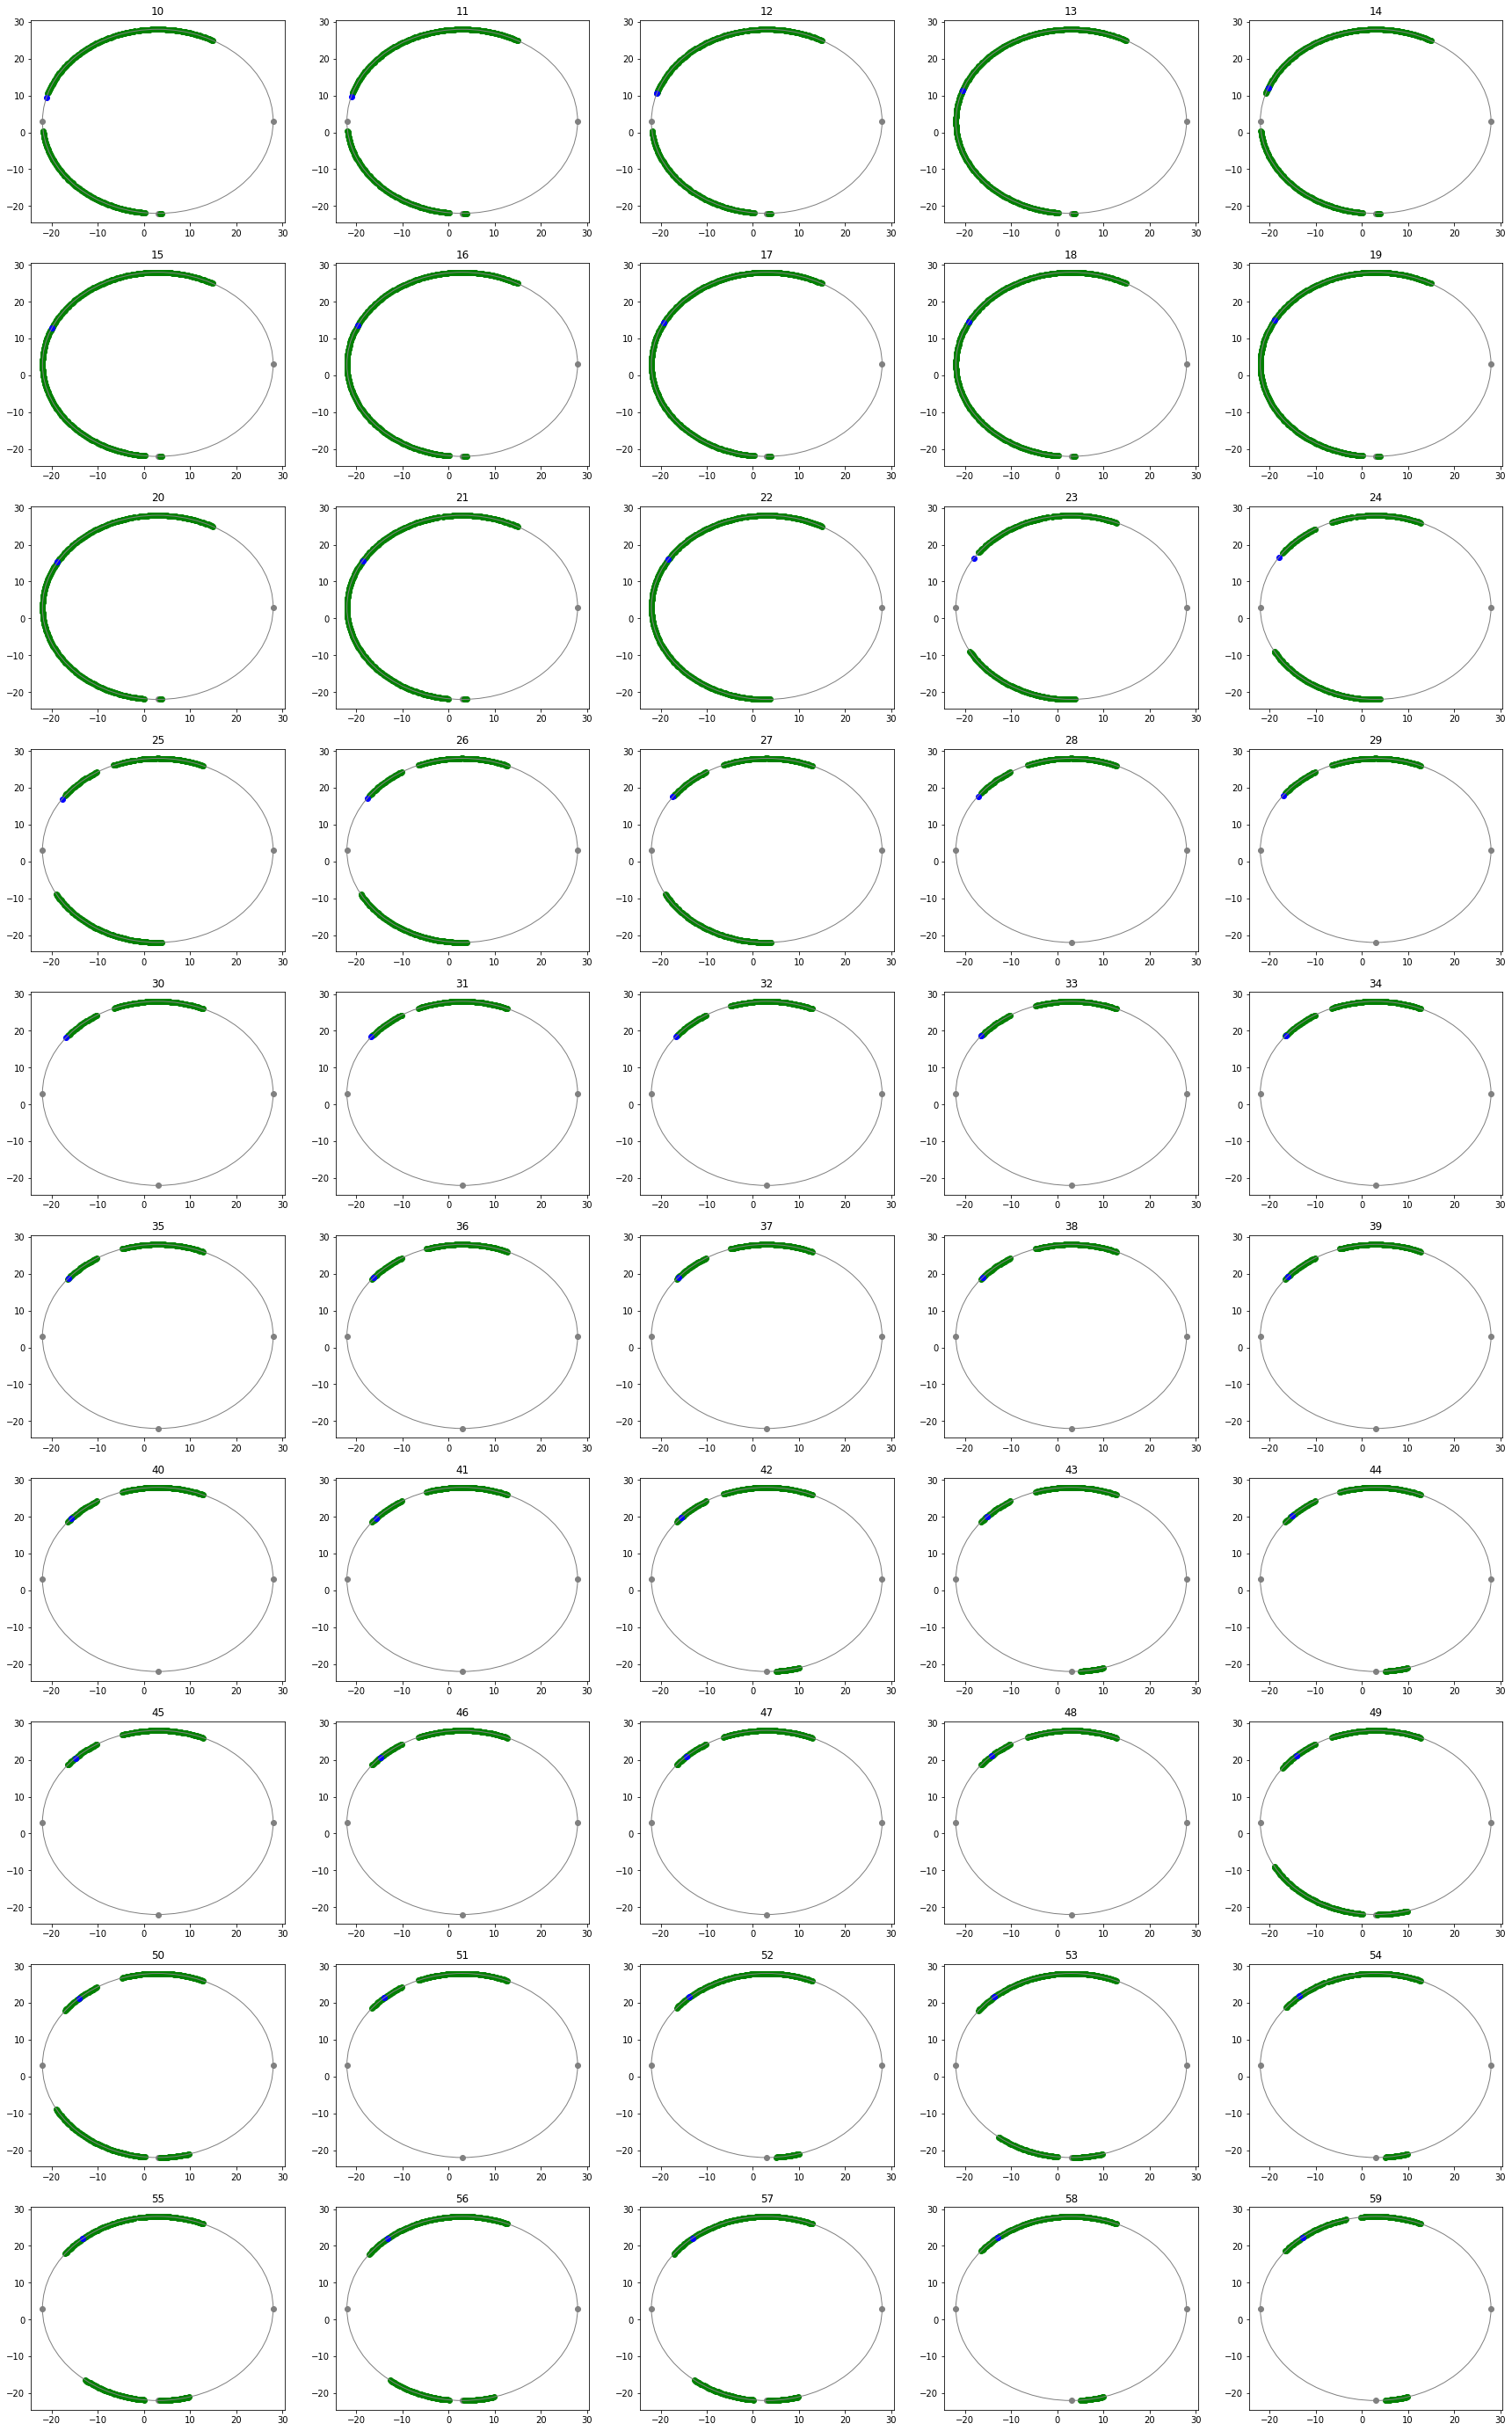

In [65]:
# get active arcs for each moment in time
start_t = 10
time_period = [start_t, start_t + 49] # start and end of the considered time period

step = 0.01
use_debug=False
use_debug_location=False

timeline = []
real_pos_timeline = []

plt.figure(figsize=(30, 50))

for i, row in full_data.iterrows():
  active_arcs = []
  active_names = []
  if i < time_period[0]:
    continue
  elif i > time_period[1]:
    break
  # check if at current time stamp neuron j is active
  for j in neurons:
    if (row[j] >= quantiles[j]):
      active_arcs.append(neuro_arcs[j])
      active_names.append(j)
  # now we have all active arcs for that specific time moment
  print(i, active_names)
  # find the position by getting the intersection of all active arcs
  cur_location_arc = [0, 2 * math.pi - 0.00001]
  res_arcs = set()
  res_arcs.add(tuple(cur_location_arc))
  for arc in active_arcs:
    new_res = []
    for sub_arc in arc:
      for r_arc in res_arcs:
        tmp_arcs = arc_intersect(list(r_arc), sub_arc)
        if (use_debug):
          print("LINKED RES:", tmp_arcs)
        new_res.extend(tmp_arcs)
    res_arcs = set(convert_to_tuples(new_res))
  res_arcs = convert_to_ll(res_arcs)
  timeline.append(res_arcs)
  if (use_debug or use_debug_location):
    print("CURRENT LOCATION AT TIME STAMP (", i, ") :", res_arcs) 
  plt.subplot(10, 5, i - time_period[0] + 1)
  plt.title(i)
  coord_X = []
  coord_Y = []
  for arc in res_arcs:
    pos = arc[0]
    while pos <= arc[1]:
      tmp_x, tmp_y = convert_from_angle(pos, 25, 3, 3)
      coord_X.append(tmp_x)
      coord_Y.append(tmp_y)
      pos += step
  circle = plt.Circle((3, 3), 25, color='gray', fill=False)
  plt.gcf().gca().add_artist(circle)
  plt.scatter([28, 3, -22, 3], [3, 28, 3, -22], c='gray')
  plt.scatter(coord_X, coord_Y, c = 'green')
  real_angle = convert_to_angle(row)
  real_x, real_y = convert_from_angle(real_angle, 25, 3, 3)
  real_pos_timeline.append((real_x, real_y))
  plt.scatter(real_x, real_y, c = 'blue') 
  # now we have the location: time to scatter some points baby!



Используем тот факт что мышь мало передвигается между фреймами чтобы улучшить результат

In [66]:
print(timeline)

[[[1.7740617499339881, 2.8349406935349974], [4.728521979600369, 4.751079103832476], [3.2504136992489125, 4.601481126456408], [1.0714223581994013, 1.7439823481416976]], [[1.0714223581994013, 2.8349406935349974], [4.728521979600369, 4.751079103832476], [3.2504136992489125, 4.601481126456408]], [[1.7740617499339881, 2.8349406935349974], [4.728521979600369, 4.751079103832476], [3.2504136992489125, 4.601481126456408], [1.0714223581994013, 1.7439823481416976]], [[4.728521979600369, 4.751079103832476], [1.0714223581994013, 4.601481126456408]], [[1.0714223581994013, 2.8349406935349974], [4.728521979600369, 4.751079103832476], [3.2504136992489125, 4.601481126456408]], [[4.728521979600369, 4.751079103832476], [1.0714223581994013, 4.601481126456408]], [[4.728521979600369, 4.751079103832476], [1.0714223581994013, 4.601481126456408]], [[4.728521979600369, 4.751079103832476], [1.0714223581994013, 4.601481126456408]], [[4.728521979600369, 4.751079103832476], [1.0714223581994013, 4.601481126456408]], 

11 [[1.674061749933988, 2.934940693534997], [1.0214223581994013, 1.8439823481416977], [1.624061749933988, 1.8439823481416977], [4.728521979600369, 4.751079103832476], [3.2004136992489127, 4.6514811264564075], [1.674061749933988, 1.8939823481416977]]
12 [[1.624061749933988, 2.8849406935349973], [4.678521979600369, 4.701481126456407], [4.728521979600369, 4.751079103832476], [3.2004136992489127, 4.6514811264564075], [1.0214223581994013, 1.8939823481416977]]
13 [[1.624061749933988, 2.934940693534997], [4.728521979600369, 4.751079103832476], [4.628521979600369, 4.6514811264564075], [4.678521979600369, 4.701481126456407], [4.678521979600369, 4.751079103832476], [3.150413699248913, 4.6514811264564075], [1.0214223581994013, 1.8939823481416977]]
14 [[1.0214223581994013, 2.984940693534997], [4.678521979600369, 4.701481126456407], [4.678521979600369, 4.751079103832476], [4.628521979600369, 4.6514811264564075], [4.728521979600369, 4.751079103832476], [3.100413699248913, 4.6514811264564075]]
15 [[1

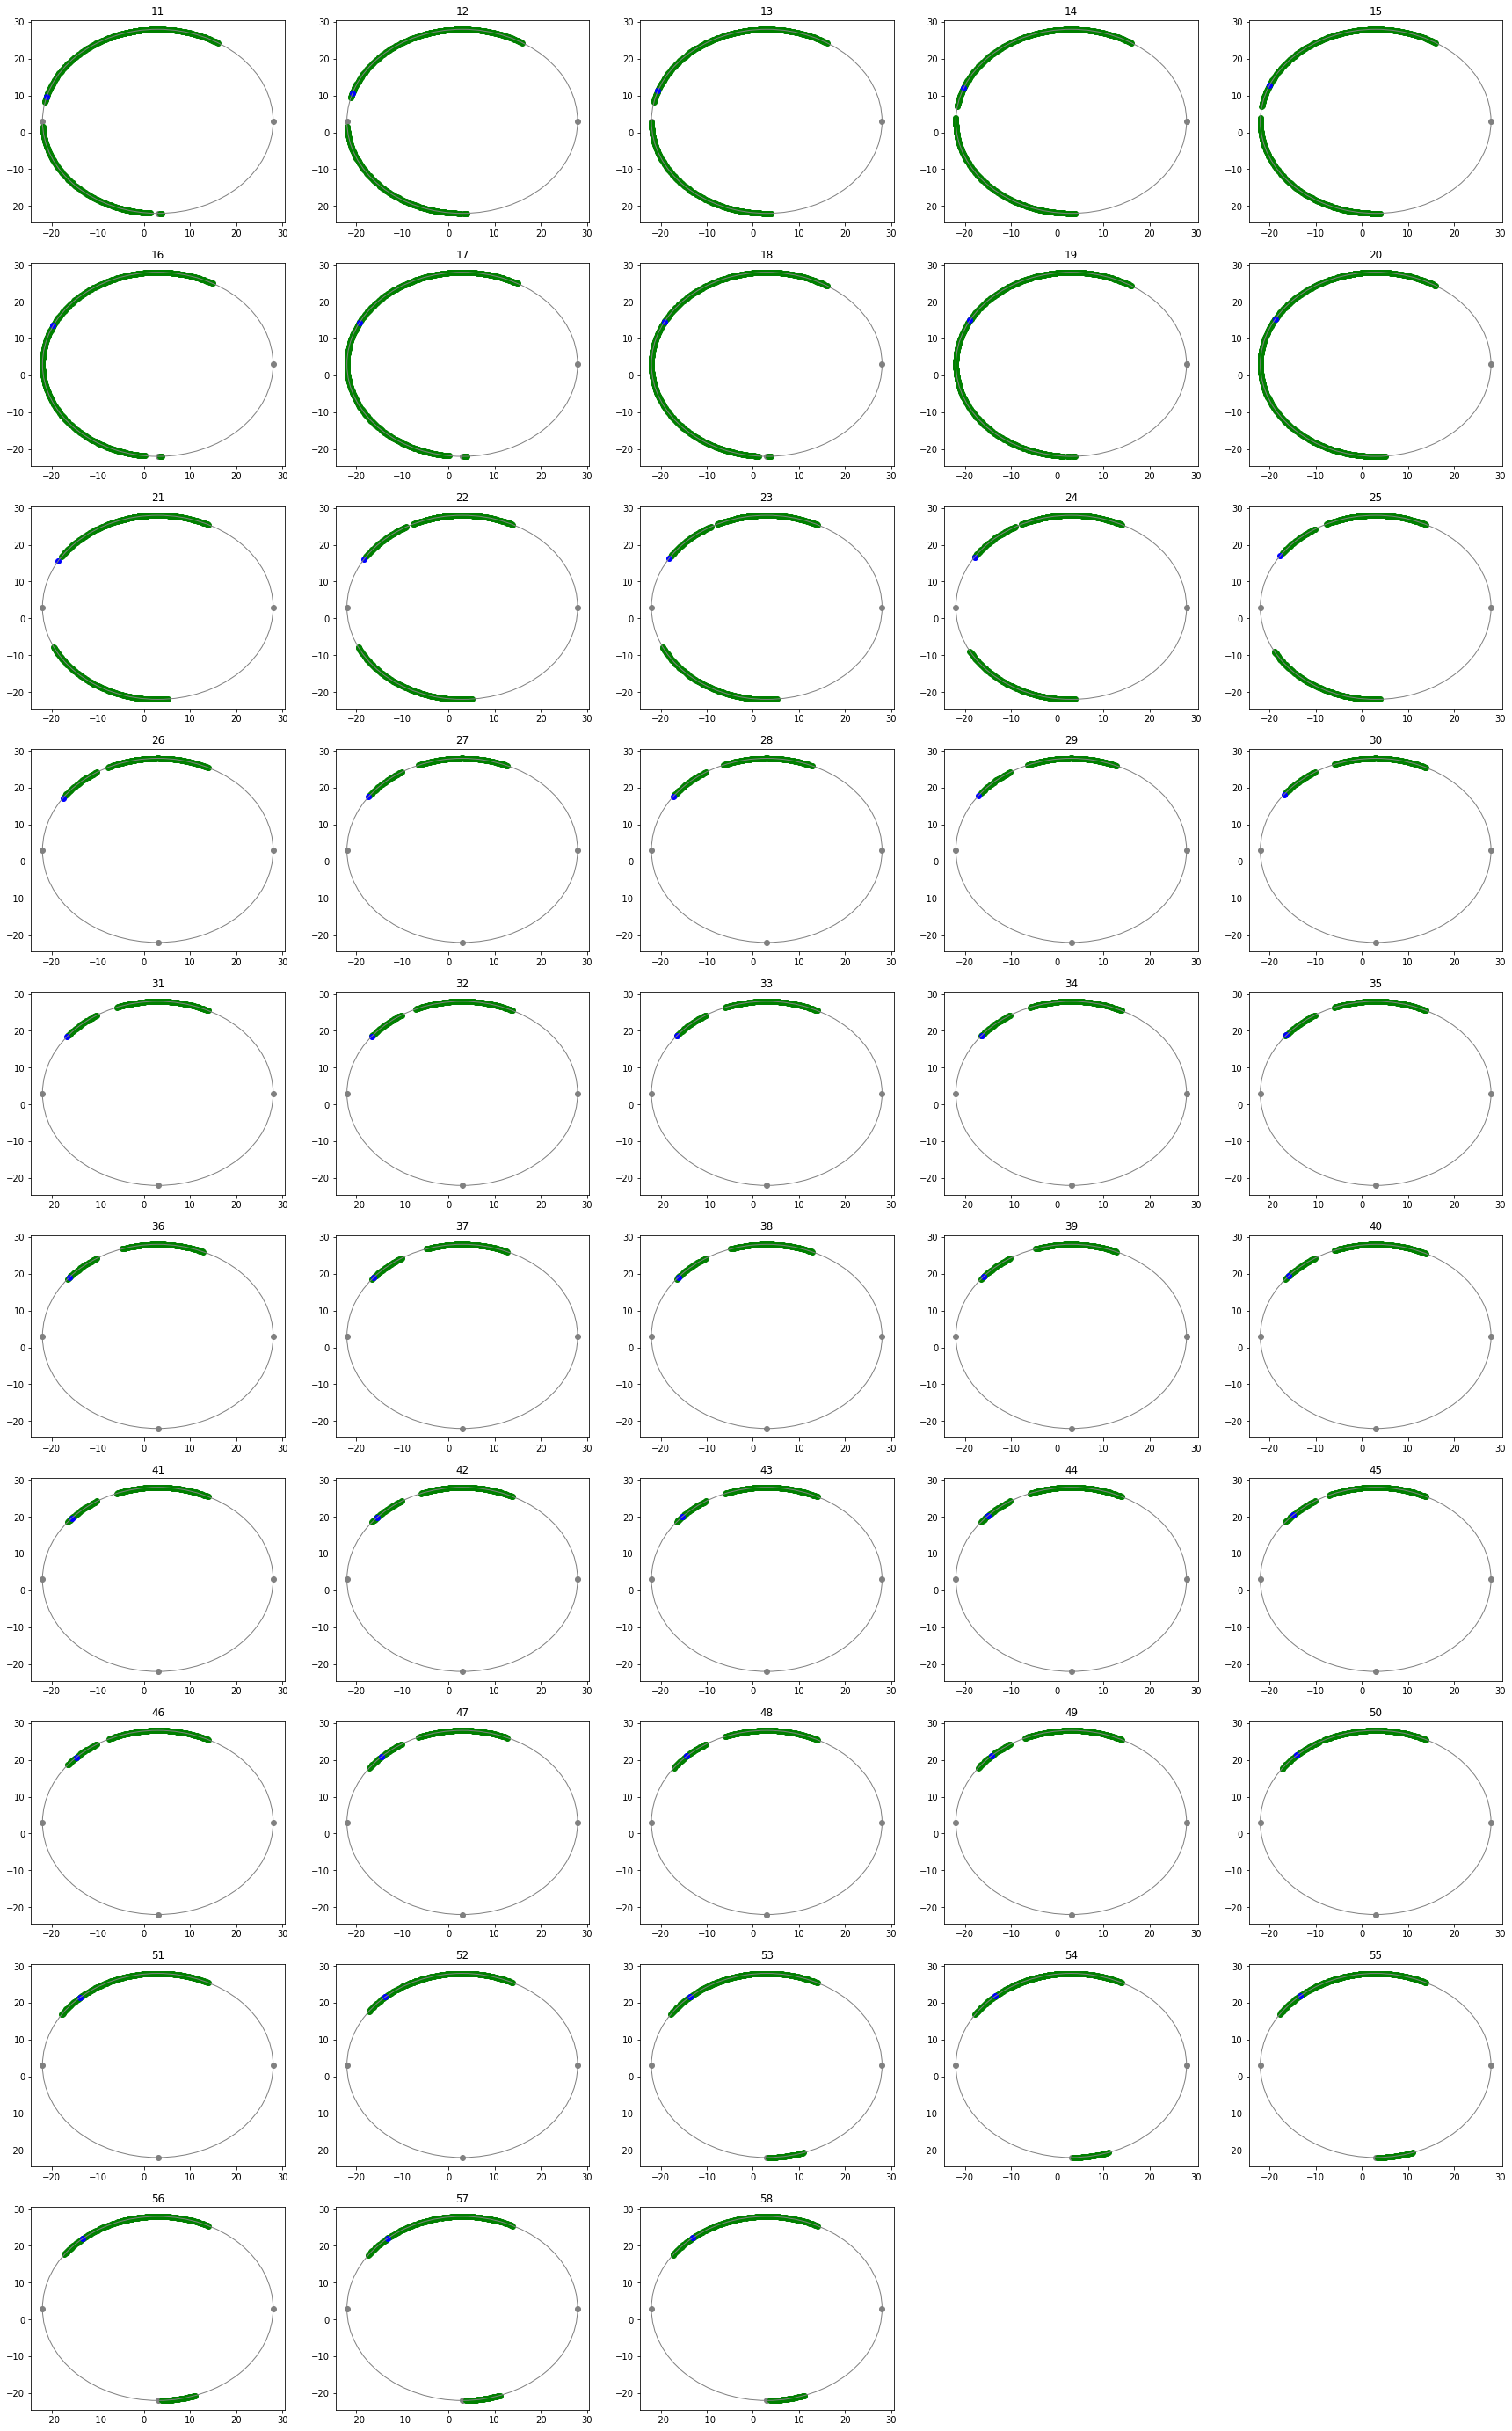

In [71]:
def inflate_arc_tuple(arc, amount=0.05):
  #print(arc)
  arc_1, arc_2 = arc
  arc_1 = max(0, arc_1 - amount/2);
  arc_2 = min(2 * math.pi, arc_2 + amount / 2);
  return [arc_1, arc_2]
  
def arc_set_intersect(arcs1, arcs2):
  res_arcs = set()
  for arc1 in arcs1:
    #print(arc1)
    new_res = []
    for arc2 in arcs2:
      a1, b1 = arc1
      a2, b2 = arc2
      if (abs(a1 - a2) <= inflation_amount/2 and abs(b1 - b2) <= inflation_amount/2):
        tmp_arcs = [[min(a1, a2), max(b1, b2)]]
      else:
        infl_arc = inflate_arc_tuple(arc1, amount=inflation_amount)
        r_arc = inflate_arc_tuple(arc2, amount=inflation_amount)
        tmp_arcs = arc_intersect(r_arc, infl_arc)
      new_res.extend(tmp_arcs)
    res_arcs |= set(convert_to_tuples(new_res))
  return res_arcs

1
inflation_amount = 0.1


prev_frame = None
new_timeline = []
plt.figure(figsize=(30, 50))
for j in range(1, len(timeline)-1):
  pprev_frame = None
  if (j > 1):
    set(convert_to_tuples(timeline[j - 2]))    
  prev_frame = set(convert_to_tuples(timeline[j - 1]))
  cur_frame = set(convert_to_tuples(timeline[j]))
  next_frame = set(convert_to_tuples(timeline[j + 1]))
  nnext_frame = None
  if (j < len(timeline)-2):
    nnext_frame = set(convert_to_tuples(timeline[j + 2]))
  cur_arcs = cur_frame.copy()
  if (pprev_frame != None):
    res_arcs = arc_set_intersect(cur_arcs, pprev_frame)
    cur_arcs = res_arcs.copy()
  res_arcs = arc_set_intersect(cur_arcs, prev_frame)
  cur_arcs = res_arcs.copy()
  res_arcs = arc_set_intersect(cur_arcs, next_frame)
  if (nnext_frame != None):
    cur_arcs = res_arcs.copy()
    res_arcs = arc_set_intersect(cur_arcs, nnext_frame)
  res_arcs = convert_to_ll(res_arcs)
  print(j + time_period[0], res_arcs)
  new_timeline.append(res_arcs)
  plt.subplot(10, 5, j)
  plt.title(j + time_period[0])
  coord_X = []
  coord_Y = []
  for arc in res_arcs:
    pos = arc[0]
    while pos <= arc[1]:
      tmp_x, tmp_y = convert_from_angle(pos, 25, 3, 3)
      coord_X.append(tmp_x)
      coord_Y.append(tmp_y)
      pos += step
  circle = plt.Circle((3, 3), 25, color='gray', fill=False)
  plt.gcf().gca().add_artist(circle)
  plt.scatter([28, 3, -22, 3], [3, 28, 3, -22], c='gray')
  plt.scatter(coord_X, coord_Y, c = 'green')
  
  real_x, real_y = real_pos_timeline[j]
  plt.scatter(real_x, real_y, c = 'blue') 

# Новый эксперимент

В новом эксперименте мышь передвигается по области имеющей 3 припятствия.

Адаптируем подход для решения задачи с областью имеющей форму окружности для нового эксперимента.


In [73]:
data = pd.read_csv('/content/drive/My Drive/New Experiment/merged_coord_traces/CA1_22_HT1_coord_traces.csv')
data.head()

Unnamed: 0  time_s           x  ...    551.0   552.0   553.0
0           0   97.50  366.655833  ... -0.84710 -5.1904 -1.8063
1           1   97.55  403.527262  ... -0.76510 -3.0929 -1.9141
2           2   97.60  442.029643  ...  0.25306 -5.9667 -1.9304
3           3   97.65  481.343690  ...  0.35090 -4.8082 -2.0714
4           4   97.70  521.092976  ...  1.18350 -5.4196 -1.2815

[5 rows x 558 columns]

In [74]:
coords = data[['x', 'y']].values
neuro = data.copy(deep=True)
neuro.drop(['time_s', 'Unnamed: 0', 'x', 'y'], inplace=True, axis=1)
neuro.rename({str(x) + '.0': x for x in range(554)}, axis=1, inplace=True)
full_data = pd.concat([neuro, data[['x', 'y']]], axis=1)

In [75]:
full_data

0        1         2  ...      553           x           y
0     -0.014918  0.69177 -0.371590  ... -1.80630  366.655833  338.619881
1      0.070134  0.49491 -0.596020  ... -1.91410  403.527262  366.761310
2      0.032137  0.53456 -0.229160  ... -1.93040  442.029643  393.603214
3     -0.007474  0.57610 -0.225370  ... -2.07140  481.343690  419.785238
4     -0.007525  0.40741 -0.151370  ... -1.28150  521.092976  445.564286
...         ...      ...       ...  ...      ...         ...         ...
13286  0.038816  2.91510 -0.471330  ...  0.37976  841.889167  567.566786
13287 -0.012692  2.96680  0.054706  ... -1.07630  785.802024  529.652619
13288  0.007388  1.72020  0.157750  ... -0.65472  729.704405  491.740714
13289  0.028078  2.25920  0.159070  ... -0.93505  673.576310  453.832500
13290 -0.033202  2.72030  0.254950  ... -0.07559  617.440595  415.932976

[13291 rows x 556 columns]

In [76]:
plt.plot(coords[:, 0], coords[:, 1])

In [77]:
activation_quantile = 0.87

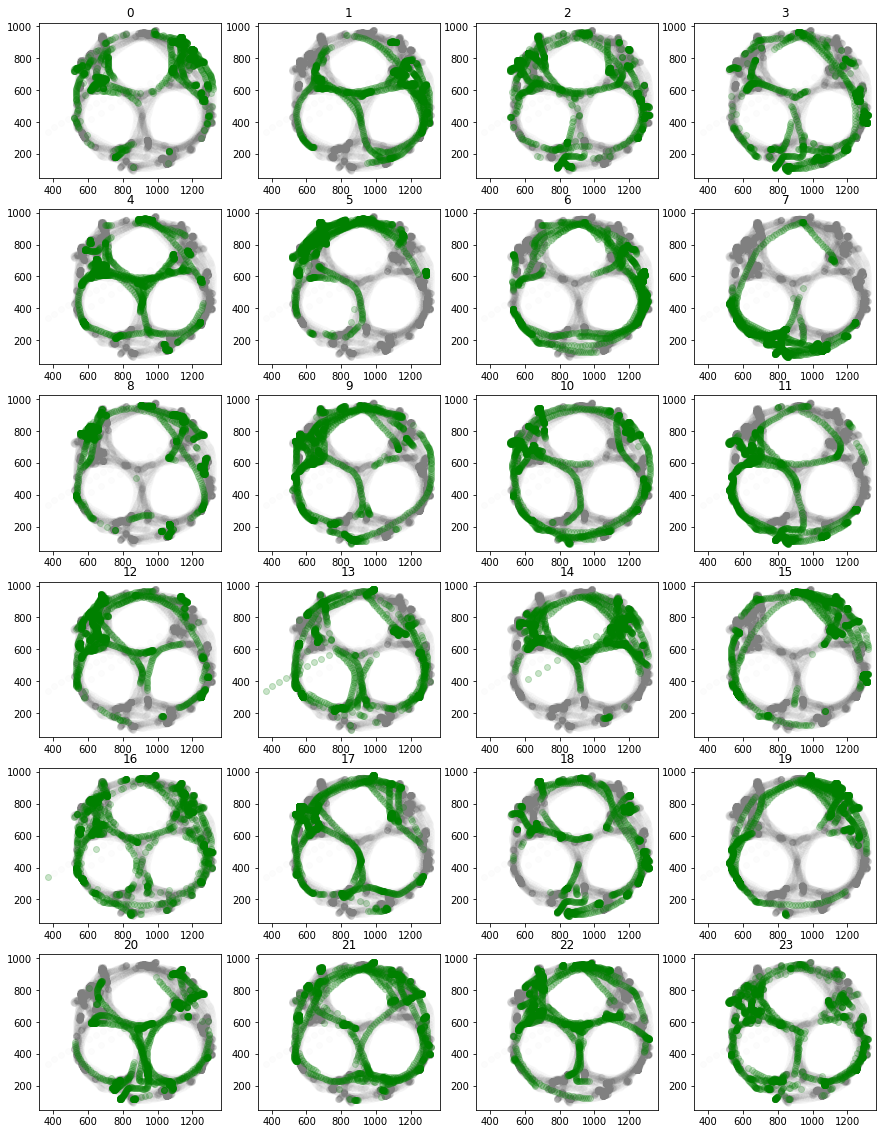

In [78]:
cols = neuro.columns[:24].astype(int)
quantiles = neuro.quantile(activation_quantile)
plt.figure(figsize=(15, 20))
for i, neur in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.title(neur)
    
    active_state = (neuro[neur] > quantiles[neur]).values
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.02, c = 'gray')
    plt.scatter(coords[active_state][:, 0], coords[active_state][:, 1], alpha=.2, c = 'green')

Каждому нейрону будем соответствовать множество точек плоскости. 

Для нахождения пересечения, таким образом достаточно находить пересечение множеств. 

Чтобы пересечение было корректным, увеличим плотность точек искусственно добавляя точки между тремя точками найденной области, такими, что расстояние между любой из них меньше заданного радиуса. Затем, округлив значения координат, получим набор точек на сетке заданной мелкости. Плотность точек области гарантирует корректное представление данной области на сетке. Пересечение областей будет корректно, там как все области представлены набором точек на сетке. Пересечение гарантировано так же будет набором точек на сетке. 

Важно что сетка должна быть не мельче, чем максимальное расстояние между соседними точками одного "облака" точек

Таким образом сопоставление области нейрону работает в два этапа:


1.   Уплотнение
2.   Выравнивание по сетке



## Выравнивание по сетке

In [79]:
def snap_to_grid(point, grid_size=0.01):
  return (math.floor(point['x'] / grid_size) * grid_size, math.floor(point['y'] / grid_size) * grid_size)

def series_to_tuple(point):
  return (point['x'], point['y'])

def get_point_cloud(data, grid_size=0.01, debug=False):
  points = data.loc[:,'x':].copy()
  points.apply(snap_to_grid, axis=1)
  point_cloud = set()
  for i, point in points.iterrows():
    #print(point)
    point_cloud.add(series_to_tuple(point))
  return point_cloud


Механизм уплотнения очень прост. Визуализацию уплотнения для трех точек одной области можно посмотреть [тут](https://www.desmos.com/calculator/geq2ytadmd)

## Алгоритм уплотнения

In [80]:
def get_center(point1, point2, point3):
  x1, y1 = point1
  x2, y2 = point2
  x3, y3 = point3 
  return ((x1 + x2 + x3)/3, (y1 + y2 + y3)/3)

def line_check(point1, point2, point3):
  x1, y1 = point1
  x2, y2 = point2
  x3, y3 = point3 
  return ((x3 - x1) * (y2 - y1)) == ((y3 - y1) * (x2 - x1))

def p_dist_sqr(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  return (x1 - x2) ** 2 + (y1 - y2) ** 2

def tri_point_dist(points):
  p1, p2, p3 = points
  return max(p_dist_sqr(p1, p2), p_dist_sqr(p1, p2), p_dist_sqr(p2,p3))

def condense_points(data, radius=0.025):
  points = data.loc[:,'x':].copy()
  condensed_points = pd.DataFrame(columns=['x','y'])
  point_set = set()
  point_groups = dict()
  for i, point in points.iterrows():
    #print(point)
    r_point = snap_to_grid(point, radius / 10)
    point_set.add(r_point)
    center_pos = snap_to_grid(point, 2 * radius)
    if (center_pos not in point_groups.keys()):
        point_groups[center_pos] = set()
    point_groups[center_pos].add(r_point)
  
  total_point_count = 0
  for center_pos in point_groups.keys():
    sz = len(point_groups[center_pos])
    #print("current group size of ",sz)
    used_triangles = set()
    if (sz <= 16):
      iter_count =  min(sz ** 2, (sz ** 3 - 3* sz ** 2 + 2 * sz) // 6)
    else:
      iter_count = 256 + 13
    added_point_count = 0
    for i in range(max(iter_count,0)):
      selection = random.sample(point_groups[center_pos], 3)
      hashable_selection = tuple(sorted(selection))
      cur_len = len(used_triangles)
      used_triangles.add(hashable_selection)
      #print("Selecting points...")
      attempts = 0
      while (cur_len == len(used_triangles)) and ((tri_point_dist(hashable_selection) >= radius / 2) or (attempts >= min(60, (sz ** 3 - 3* sz ** 2 + 2 * sz) // 6))):
        attempts += 1
        selection = random.sample(point_groups[center_pos], 3)
        hashable_selection = tuple(sorted(selection))
        used_triangles.add(hashable_selection)
      #print(i)
      if not line_check(selection[0], selection[1], selection[2]):
        x, y = get_center(selection[0], selection[1], selection[2])
        condensed_points = condensed_points.append({'x': x, 'y': y}, ignore_index=True)
        
        added_point_count += 1
      for k in range(2):
        for k1 in range(k + 1, 3):
          x1, y1 = selection[k]
          x2, y2 = selection[k1]
          x, y = (0.5 * (x1 + x2),  0.5 * (y1 + y2))
          condensed_points = condensed_points.append({'x': x, 'y': y}, ignore_index=True)
          added_point_count += 1
    total_point_count += added_point_count
  #print(total_point_count)
  return condensed_points 
  

In [84]:
start_t = 0
end_t = start_t + 12
radius = 60

Got point cloud for neuron  1
Got point cloud for neuron  2
Got point cloud for neuron  3
Got point cloud for neuron  4
Got point cloud for neuron  5
Got point cloud for neuron  6
Got point cloud for neuron  7
Got point cloud for neuron  8
Got point cloud for neuron  9
Got point cloud for neuron  10
Got point cloud for neuron  11
Got point cloud for neuron  12


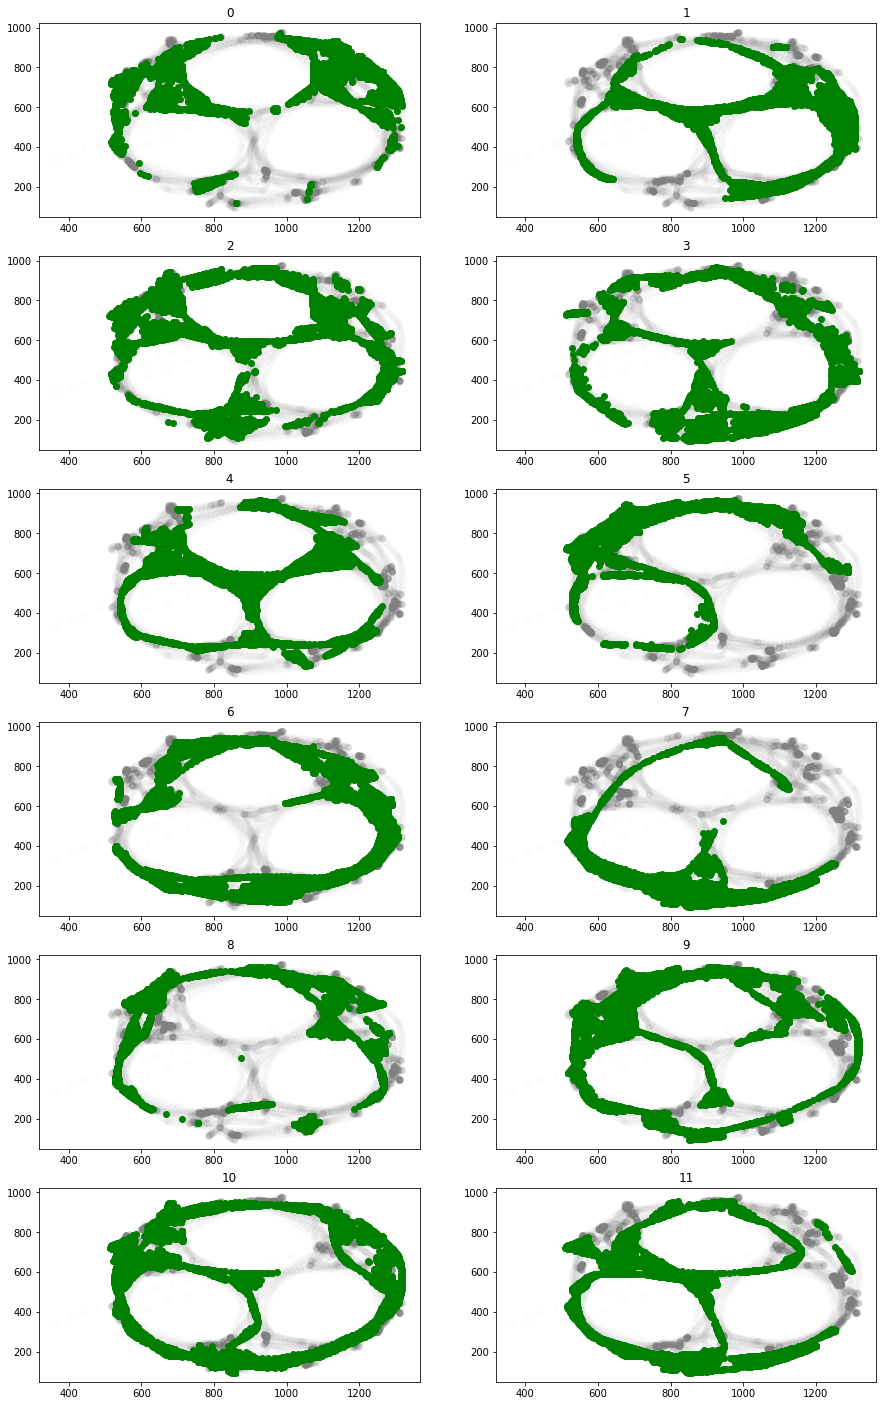

In [ ]:
new_data = full_data.copy(deep=True)
quantiles = new_data.quantile(activation_quantile)
cols = new_data.iloc[:, start_t:end_t].copy().astype(int)
plt.figure(figsize=(15, 25))


neuro_clouds = []
for i, col in enumerate(cols):
  plt.subplot(6, 2, i + 1)
  plt.title(col)
  plt.scatter(coords[:, 0], coords[:, 1], alpha= 0.02, c = 'gray')
  active_state = (new_data[col] > quantiles[col]).values
  condensed_points = condense_points(new_data[active_state], radius)
  condensed_points = condensed_points.append(new_data[active_state], ignore_index=True)
  neuro_clouds.append(get_point_cloud(condensed_points, radius // 3))
  print("Got point cloud for neuron ", i + 1)
  points_x = [x for x, y in neuro_clouds[-1]]
  points_y = [y for x, y in neuro_clouds[-1]]
  plt.scatter(points_x, points_y, c = 'green')

## Нахождение лучших нейронов

Найдем лучшие 250 нейронов по показателю взаимной информации

In [81]:
mis = []

n_labels = 10
X = quantile_transform(neuro)
X_labels = (X * 15).astype(np.int32)
kmeans = KMeans(n_clusters=15, random_state=0).fit(coords)
Y = np.hstack([coords, kmeans.labels_.reshape(-1, 1)])
for x in X_labels.T:
    mis.append(mutual_info_score(x, Y[:, 2]))
mis = np.array(mis)
entropy = mutual_info_score(Y[:, 2], Y[:, 2]) / np.log(2)
best_neurons = np.argsort(-mis)[:250]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


In [82]:
print(best_neurons)

[101 165 223 213 196 131  68 118  78   7 130  29 148 189  80  73 313  51
 181 328 107  31 265 350  92  97 150  35  58 233 137 495  77 195 209 253
 229 362 221   5 281  75 156  19 120 256 487  47  81 360 151 331 134 140
 269 236 354  96 334  59 211  49 139 347  72  70 110 288  84  89 125  22
 307   1 262 340 290 106 345 160 129 124 244 389 159 390 462 305 179 267
 261 463 271  14 285 304 294 451  25  32  44 406  55 178  57  83 116 176
 371 126 341 105 296 166 121 147  65 274 218  99 409  48  17 182 393 115
 208  15 315 100  11  79   8 114 230  94 319 337 398  36 186 157 141 135
 119 363   0 249 329 162 325 388 240 228 241  87  27 158 258 217 259 136
 332  71 336 317 184 257 410  39 444 493 190 180 416 188 475 377 238 145
 513 311 402 457 465 146  82 117 339 277  88 456 215   6 144   9 364 272
  64 220 318  45 278  60  20 251 243 198 433  53 449 255 197 239 445 411
 109  12 250   4 408 468 316 143 323  28 452  34  66 174 286 175 222 123
 472 486 412 381 383 270 154 161 351 386 421 302  8

Warning: Run at your own risk - all clouds have been precomputed previously

In [ ]:
new_data = full_data.copy(deep=True)
quantiles = new_data.quantile(activation_quantile)
cols = new_data.copy().astype(int)

all_neuro_clouds = [dict()]
for i, col in enumerate(cols):
  if (col not in best_neurons):
    continue
  active_state = (new_data[col] > quantiles[col]).values
  condensed_points = condense_points(new_data[active_state], radius)
  condensed_points = condensed_points.append(new_data[active_state], ignore_index=True)
  point_cloud = get_point_cloud(condensed_points, radius//3)
  with open('/content/drive/My Drive/New Experiment/point_clouds/' + str(col), 'w') as filehandle:
    filehandle.writelines("%s\n" % str(point) for point in point_cloud)
  print("saved neuron data to file")
  all_neuro_clouds.append(point_cloud)

##Нормировка данных для калибровки

In [86]:
def calc_norm_coef2(data, time_period, radius=60):
  coefs = dict()
  points = set()
  occurances = dict()
  active_arcs = []
  active_names = []
  for i, row in data.iterrows():
    if i < time_period[0]:
      continue
    elif i > time_period[1]:
      break  
    point = snap_to_grid(row, radius)
    l = len(points)
    points.add(point)
    if l <= len(points):
      occurances[point] = 1
    else:
      occurances[point] += 1
  for point in points:
    coefs[point] = 1/occurances[point]
  return coefs
        

In [167]:
def inflate_point(point, radius, grid_size):
  x, y = point
  point_set = set()
  start_angle = 0
  for i in range(2):
    r = radius / (i + 1)
    while (start_angle < 2 * math.pi):
      angle = start_angle
      for i in range(2):
        x1 = x + r * math.cos(angle)
        y1 = y + r * math.sin(angle)
        angle += 2 * math.pi / 3
        point_set.add((math.floor(x1 / grid_size) * grid_size, math.floor(y1 / grid_size) * grid_size))
      start_angle += math.pi/4
    point_set.add(point)
  return point_set

def cloud_min_dist(point, point_cloud):
  min_dist = math.inf
  for cur_point in point_cloud:
    cur_dist = p_dist_sqr(point, cur_point) 
    if (cur_dist < min_dist):
      min_dist = cur_dist
  return math.sqrt(min_dist)

def calc_score_func2(full_data, neuro_clouds, time_period, neurons, grid_size, norm_coef, penalty=-1000, inflation_amount=1.5, inverse_penalty_rule=False, debug=False):
  res_info = [0, 0, 0, 0] # totalScore, no itersection count, error count

  for i, row in full_data.iterrows():
    active_clouds = []
    active_names = []
    if i < time_period[0]:
      continue
    elif i > time_period[1]:
      break
    # check if at current time stamp neuron j is active
    for j in neurons:
      if (row[j] >= quantiles[j]):
        active_clouds.append(neuro_clouds[j])
        active_names.append(j)
    flag = False
    sum_length = 0
    if (len(active_clouds) == 0):
      continue
    cur_location = active_clouds[0].copy()
    real_pos = snap_to_grid(row, grid_size)
    for cloud in active_clouds:
      if (cloud != cur_location):
        cur_location &= cloud
    if (len(cur_location) == 0):
      res_info[1] += 1
      res_info[0] += penalty * norm_coef[real_pos]
      continue
    if (real_pos not in cur_location):
      inflated_pos = cur_location & inflate_point(real_pos, inflation_amount * grid_size, grid_size)
      if (len(inflated_pos) > 0):
        avg_coef = 0
        for el in inflated_pos:
          if (el in norm_coef.keys()):
            avg_coef += 1/len(inflated_pos) * norm_coef[el]
        avg_coef = 0.5 * avg_coef + 0.5 * norm_coef[real_pos]
        res_info[0] += 1000 * avg_coef * ((1 /len(cur_location | inflated_pos)) - (1 / len(full_data.index)))
      else:
        res_info[0] += penalty * norm_coef[real_pos] * cloud_min_dist(real_pos, cur_location)/1000
        res_info[3] += penalty * cloud_min_dist(real_pos, cur_location)/1000
        res_info[2] += 1
    else:
      res_info[0] +=  1000 * norm_coef[real_pos] * ((1 /len(cur_location)) - (1 / len(full_data.index)))
  return res_info


In [89]:
all_neuro_clouds = dict()
for neuron in best_neurons:
  cur_neuro_cloud = set()
  with open('/content/drive/My Drive/New Experiment/point_clouds/' + str(neuron), 'r') as reader:
    while True:
      line = reader.readline()
      if (line == ''):
        break
      x, y = map(float, line[1:-2].split(', '))
      cur_neuro_cloud.add((x, y))
  all_neuro_clouds[neuron] = cur_neuro_cloud
  

In [90]:
print(all_neuro_clouds[50])

{(696.0, 744.0), (1143.0, 732.0), (1269.0, 513.0), (1204.3827380952416, 576.013690476188), (638.0, 752.0), (1305.7227380952386, 451.0102380952375), (1305.1965476190478, 451.89452380952315), (994.0, 580.0), (904.0, 420.0), (777.0, 186.0), (815.4247619047604, 598.0348809523831), (1040.0, 624.0), (1020.0, 912.0), (678.0, 746.0), (1008.0, 616.0), (1032.3770238095242, 928.3767857142856), (627.0, 750.0), (789.0, 579.0), (705.0, 648.0), (848.0, 144.0), (904.0, 130.0), (1137.0, 798.0), (1244.0, 534.0), (1119.0, 666.0), (808.0, 574.0), (878.0, 268.0), (1071.0, 615.0), (868.0, 290.0), (892.0, 440.0), (770.0, 614.0), (916.0, 920.0), (1054.0, 642.0), (1257.0, 534.0), (562.0, 708.0), (1042.0, 186.0), (1314.0, 567.0), (875.5277380952382, 407.4522619047608), (912.6477380952388, 411.9192857142802), (666.0, 678.0), (1146.0, 774.0), (900.0, 372.0), (1293.7211904761893, 459.23535714286044), (1293.0, 459.0), (1149.0, 753.0), (909.0, 450.0), (876.0, 123.0), (1028.0, 904.0), (880.0, 126.0), (662.0, 666.0), 

## Жадный алгоритм

In [162]:
max_errors = 0.05
max_no_sol = 0.01
max_avg_error = 0.006
radius = 20
penalty = -25

In [163]:
pos_neurons = set()
sorted_neurons = []
time_period = [10, 3000]
time_period_len = time_period[1] - time_period[0]
norm_coef = calc_norm_coef2(full_data.copy(), time_period, radius)
for neuron in best_neurons:
  res = calc_score_func2(full_data.copy(), all_neuro_clouds, time_period, [neuron], radius, norm_coef, penalty, 2)
  if (res[1] <= max_no_sol * time_period_len  and res[2] <= max_errors * time_period_len and (res[2] == 0 or res[3]/(penalty * res[2]) <= max_avg_error)):
    tmp_len = len(pos_neurons)
    pos_neurons.add(neuron)
    if (tmp_len < len(pos_neurons)):
      sorted_neurons.append([res[0], neuron])
    print(neuron, res)
sorted_neurons = sorted(sorted_neurons, key=lambda x: -x[0])

101 [5.644330327522127, 0, 68, -9.072491803270191]
165 [3.065471716197665, 0, 96, -8.717130553212302]
223 [-9.713542728379714, 0, 119, -15.463063176700564]
196 [0, 0, 0, 0]
118 [0.9446479068521744, 0, 28, -3.245375907388904]
78 [3.8281801490459375, 0, 36, -2.971473310962051]
7 [0.13319661215228945, 0, 139, -12.338890864936005]
130 [-9.737581067531327, 0, 87, -12.159475294748392]
148 [10.455394758431112, 0, 68, -6.553591982690088]
189 [14.043850563973988, 0, 24, -2.796962493199421]
80 [-8.601347703287672, 0, 117, -11.980985997108846]
313 [-2.7542054493468626, 0, 138, -9.403394781410952]
328 [24.292829083505573, 0, 21, -2.7223068167066655]
31 [2.305686977399629, 0, 0, 0]
92 [3.825988873980294, 0, 36, -3.444912093368537]
97 [7.030709529249813, 0, 109, -10.367987925829773]
233 [-0.12608319225444317, 0, 10, -0.5847221565263513]
495 [-3.3950713807715194, 0, 135, -9.460932086570514]
195 [-2.279471394477798, 0, 74, -6.80110598902227]
209 [4.4201546241633665, 0, 66, -3.8423555544247496]
362 [-4

In [168]:
print(sorted_neurons)
print(len(sorted_neurons))

[[24.292829083505573, 328], [14.043850563973988, 189], [10.455394758431112, 148], [7.030709529249813, 97], [5.644330327522127, 101], [4.8297169038139405, 81], [4.4201546241633665, 209], [3.8281801490459375, 78], [3.825988873980294, 92], [3.3790650457183453, 96], [3.065471716197665, 165], [2.6178265704733885, 1], [2.305686977399629, 31], [2.149336600405276, 66], [1.4187795258871736, 120], [1.1902208104580834, 402], [1.0396544529145384, 178], [0.9446479068521744, 118], [0.6666085489780286, 290], [0.3782769747009245, 86], [0.3590538976535055, 117], [0.13319661215228945, 7], [0.10152360500169887, 250], [0.08104138783432621, 261], [0, 196], [-0.12608319225444317, 233], [-0.38633060659433227, 82], [-0.7108611279743472, 57], [-0.8529564435149499, 406], [-0.9802008783036482, 302], [-1.0098718476910964, 371], [-1.5273978034119338, 388], [-2.279471394477798, 195], [-2.624194632063428, 84], [-2.7457790627252905, 269], [-2.7542054493468626, 313], [-2.758074210352732, 75], [-2.787995914398303, 249]

In [179]:
all_greedy_basis = []

In [191]:
good_time_frames = [[10, 60], [16, 30], [79, 90], [120, 180], [400, 460], [600, 660], [1950, 2010], [2800, 3000], [200, 800], [10, 1000]]

In [184]:
for time_period in good_time_frames:
  period_sz = time_period[1] - time_period[0]
  basis_neurons = set()
  penalty = -28
  all_sorted_neurons = set([x for s,x in sorted_neurons])
  #print(all_sorted_neurons)
  norm_coef = calc_norm_coef2(full_data, time_period, 20)
  #print(norm_coef)

  prev_best = [-999999999, 999999999, 999999999]
  cur_score = prev_best.copy()
  cur_score[0] += 1
  while prev_best[0] <= cur_score[0]:
    cur_best = [-999999999, 999999999, 999999999]
    cur_neuron = None
    if (len(basis_neurons) > 1):
      possible_neurons = set(all_sorted_neurons.copy()) - basis_neurons
    else:
      possible_neurons = all_sorted_neurons.copy()
    if (len(possible_neurons) == 0):
      break
    for neuron in possible_neurons:
      test_basis = basis_neurons.copy()
      test_basis.add(neuron)
      if test_basis != basis_neurons:
        res = calc_score_func2(full_data.iloc[(time_period[0]-1) : , :], all_neuro_clouds, time_period, test_basis, 20, norm_coef, penalty, 2)
        if res[0] > cur_best[0] and res[2]/period_sz <= 0.01 and (res[2] == 0 or res[3]/(penalty * res[2]) <= 0.006):
          cur_best = res
          cur_neuron = neuron
          #print(cur_neuron)
    if (prev_best[0] > cur_best[0]) or (prev_best[0] == cur_best[0] and prev_best[2] <= cur_best[2]):
      print("Fail:", cur_best)
      cur_score = prev_best
      break 
    basis_neurons.add(cur_neuron)
    print(basis_neurons)
    prev_best = cur_score
    cur_score = cur_best
    print(cur_score)
  print("Best: ", cur_score)
  all_greedy_basis.append(basis_neurons)

{495}
[0.33824405715824074, 0, 0, 0]
{302, 495}
[7.754608932855488, 0, 0, 0]
{233, 302, 495}
[7.838470047868687, 0, 0, 0]
{233, 1, 302, 495}
[7.838470047868687, 0, 0, 0]
Fail: [7.838470047868687, 0, 0, 0]
Best:  [7.838470047868687, 0, 0, 0]
{495}
[0.038728533300047704, 0, 0, 0]
{1, 495}
[0.038728533300047704, 0, 0, 0]
Fail: [0.038728533300047704, 0, 0, 0]
Best:  [0.038728533300047704, 0, 0, 0]
{486}
[0.07472249318742577, 0, 0, 0]
{92, 486}
[0.14126937031359169, 0, 0, 0]
{233, 92, 486}
[0.17655889817321443, 0, 0, 0]
{233, 92, 486, 1}
[0.17655889817321443, 0, 0, 0]
Fail: [0.17655889817321443, 0, 0, 0]
Best:  [0.17655889817321443, 0, 0, 0]
{393}
[0.07377553506818531, 0, 0, 0]
{456, 393}
[0.10738569967667974, 0, 0, 0]
{456, 393, 1}
[0.10738569967667974, 0, 0, 0]
Fail: [0.10738569967667974, 0, 0, 0]
Best:  [0.10738569967667974, 0, 0, 0]
{97}
[1.371737425501576, 0, 0, 0]
{97, 189}
[1.6703219566745722, 0, 0, 0]
{97, 189, 119}
[1.8667858235375643, 0, 0, 0]
{97, 162, 189, 119}
[1.92817218722715

In [189]:
for el in all_greedy_basis:
  print(el)

{233, 1, 302, 495}
{1, 495}
{233, 92, 486, 1}
{456, 393, 1}
{97, 162, 259, 119, 189}
{129, 66, 1, 261, 209, 249}
{1, 328, 136, 360, 269, 48, 145, 209, 82, 189, 94}
{1, 195, 101, 208, 337, 341}
{66, 259, 7, 136, 209, 117, 151, 249, 27}
{66, 86, 151, 189, 31}


Набор нейронов составленный из результатов работы жадного алгоритма с различными начальными базисными нейронами

In [190]:
greedy_best_neruons = set()
for el in all_greedy_basis:
  greedy_best_neruons |= el
print(greedy_best_neruons)

{1, 129, 259, 66, 261, 195, 7, 456, 393, 328, 136, 269, 208, 209, 145, 82, 337, 341, 86, 151, 27, 92, 94, 31, 97, 162, 101, 486, 360, 233, 302, 495, 48, 117, 119, 249, 189}


50 [302, 48, 97] : 546
51 [151, 302, 48, 97, 495] : 42
52 [151, 302, 48, 97, 360, 495] : 34
53 [7, 48, 97, 360] : 27
54 [7, 302, 48, 97, 360, 495] : 9
55 [7, 302, 97, 360] : 41
56 [7, 48, 97, 360, 495] : 24
57 [7, 97, 360] : 78
58 [7, 208, 94, 360, 495] : 86
59 [7, 94, 360, 233] : 136
60 [7, 208, 94, 360, 233, 495] : 53
61 [7, 208, 94, 360] : 120
62 [7, 94, 360, 495] : 181
63 [7, 208, 94, 360, 495] : 86
64 [7, 94, 360, 495] : 181
65 [7, 94, 360, 233] : 136
66 [7, 94, 360] : 304
67 [7, 94, 360] : 304
68 [7, 208, 94, 360, 233, 495] : 53
69 [7, 208, 94, 360] : 120
70 [7, 94, 360] : 304
71 [7, 94, 360] : 304
72 [7, 92, 94] : 308
73 [7, 92, 94, 360] : 167
74 [7, 208, 92, 94, 360] : 82
75 [7, 92, 94, 486, 360] : 55
76 [7, 92, 94, 360] : 167
77 [7, 92, 94, 360] : 167
78 [7, 92, 94, 360] : 167
79 [7, 92] : 3158
80 [7, 92, 495] : 1777
81 [7, 233] : 3193
82 [7] : 7675
83 [7, 233] : 3193
84 [7, 92] : 3158
85 [7, 233] : 3193
86 [7] : 7675
87 [7] : 7675
88 [7] : 7675
89 [7, 486, 495] : 363
90 [7] :

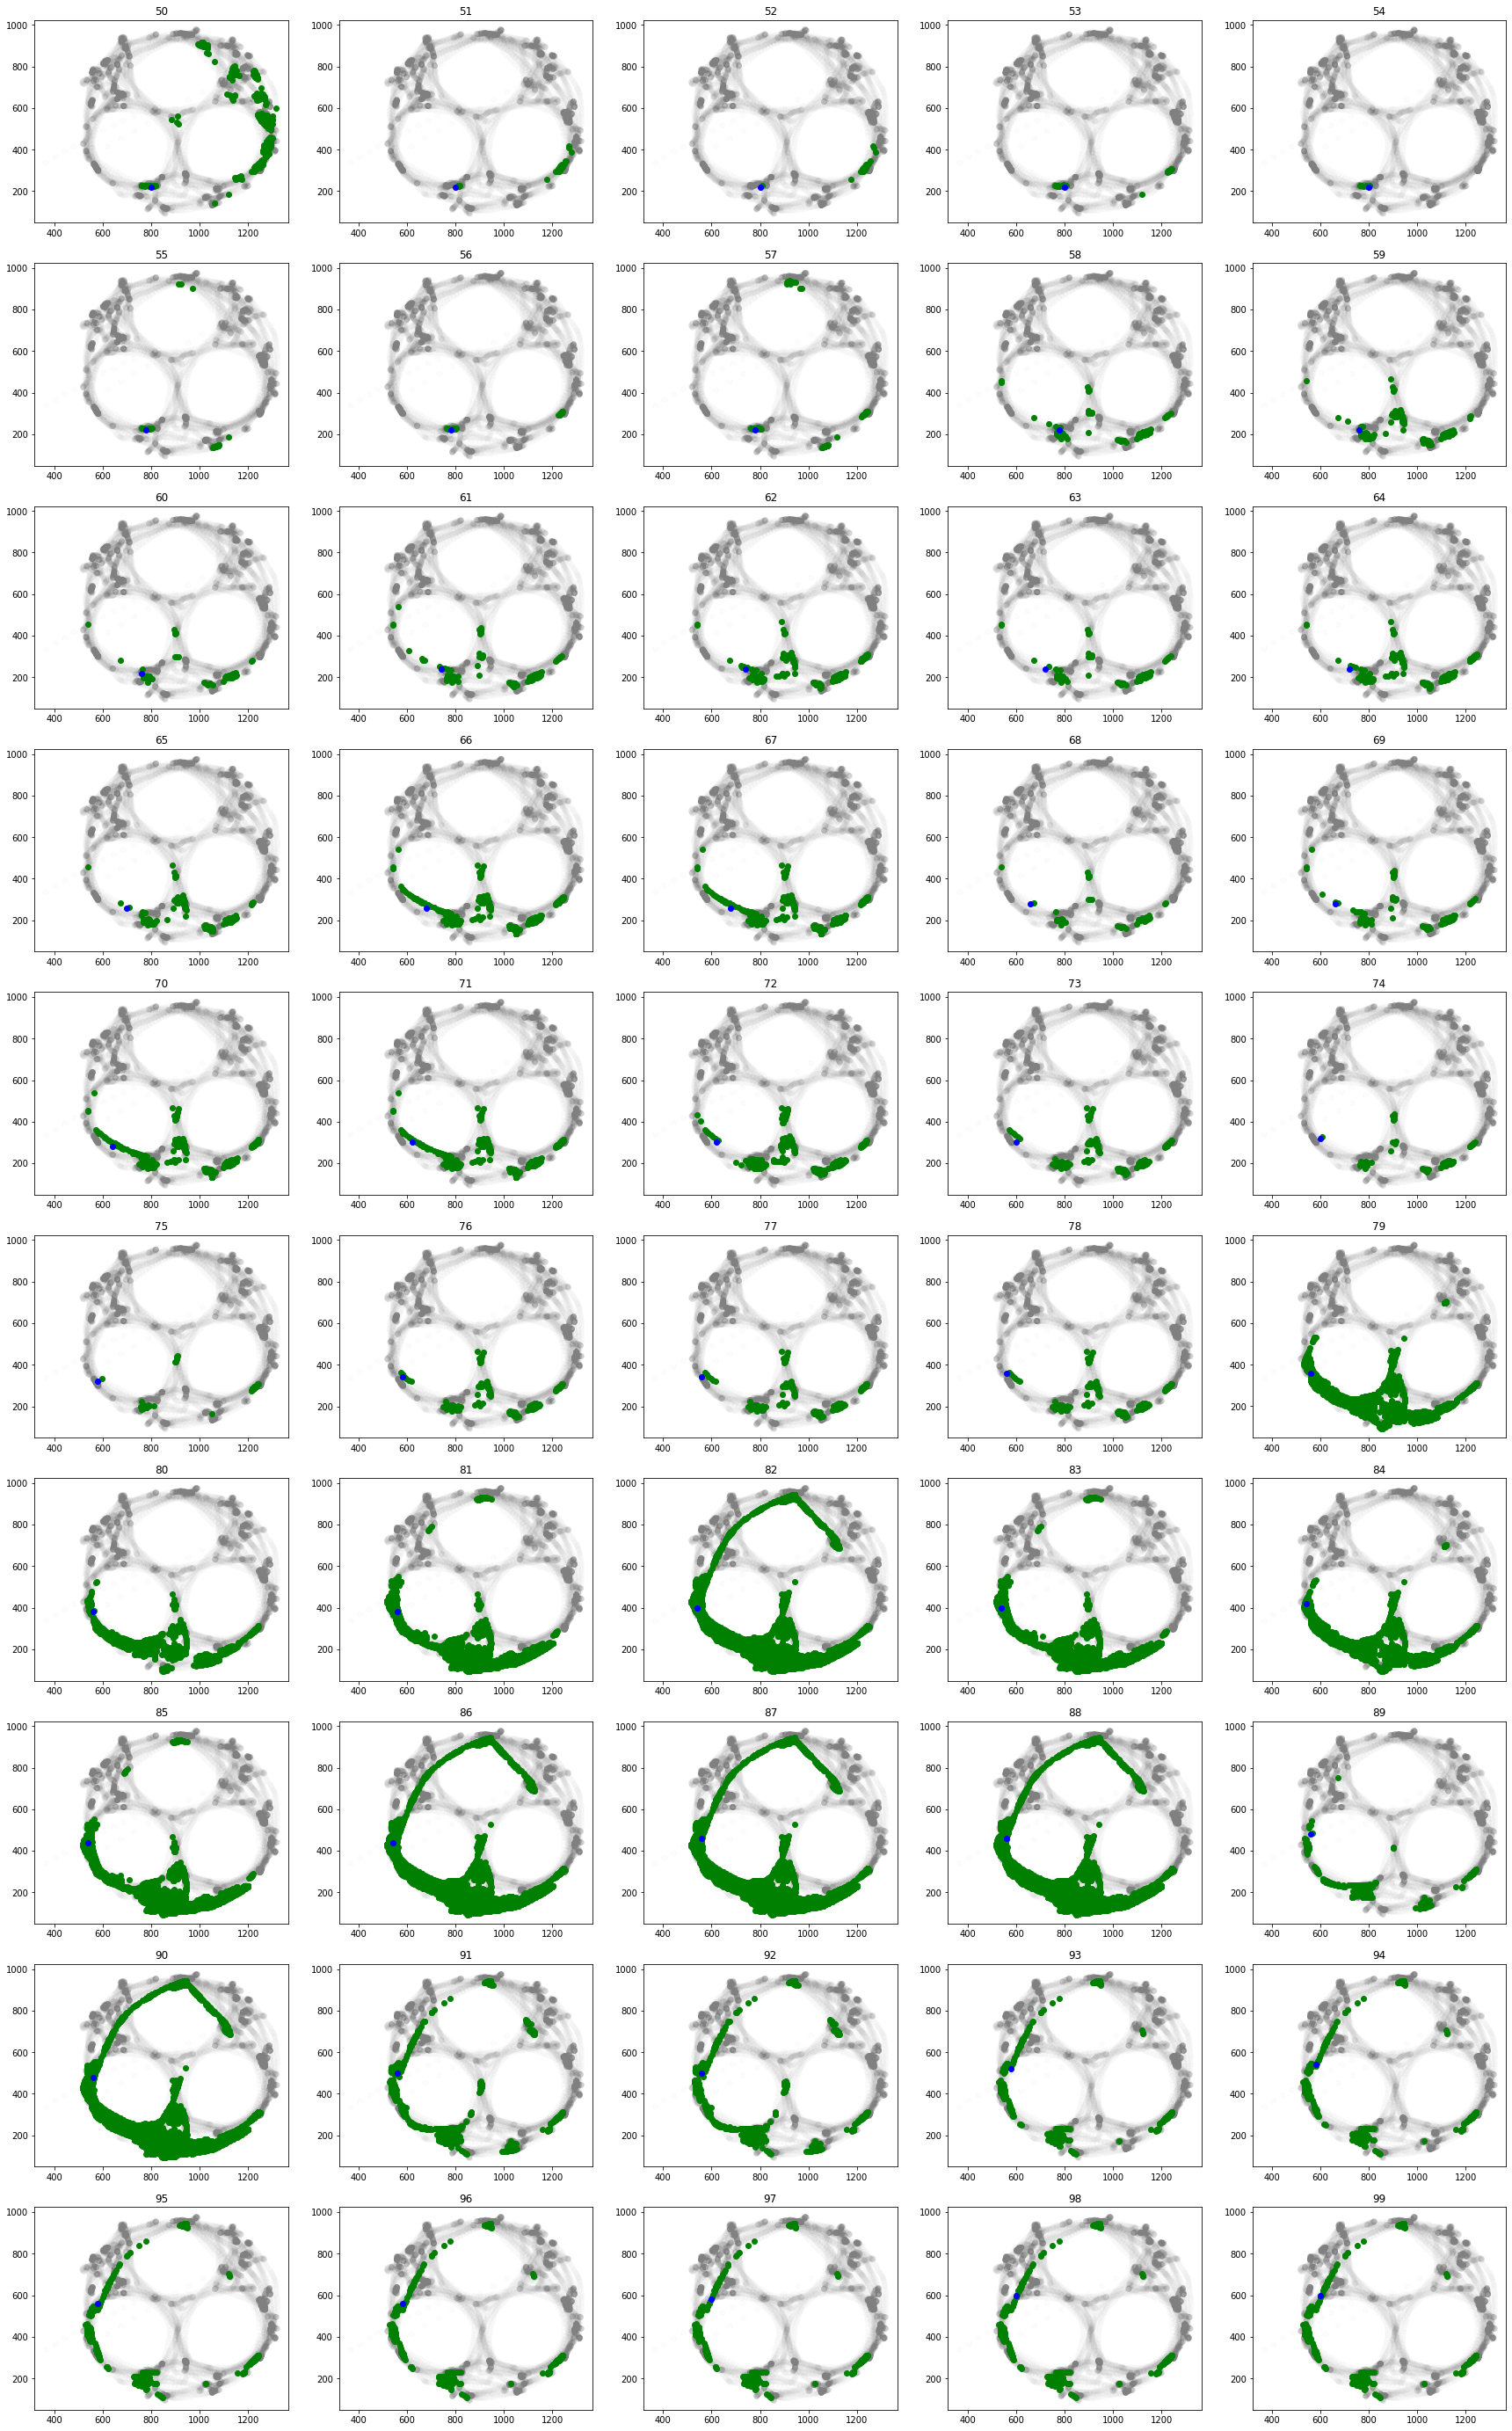

In [188]:
start_t = 50
time_period = [start_t, start_t + 49] # start and end of the considered time period
neurons = greedy_best_neruons.copy()
use_debug=False
use_debug_location=False
grid_size = 20

plt.figure(figsize=(30, 50))

for i, row in full_data.iterrows():
  active_clouds = []
  active_names = []
  if i < time_period[0]:
    continue
  elif i > time_period[1]:
    break
  # check if at current time stamp neuron j is active

  for j in neurons:
    if (row[j] >= quantiles[j]):
      active_clouds.append(all_neuro_clouds[j])
      active_names.append(j)
  print(i, active_names, end=' : ')
  if (len(active_clouds) > 0):
    cur_location = active_clouds[0].copy()
    real_pos = snap_to_grid(row, grid_size)
    for cloud in active_clouds:
      if (cloud != cur_location):
        cur_location &= cloud
    print(len(cur_location))
    plt.subplot(10, 5, i - time_period[0] + 1)
    plt.title(i)
    plt.scatter(coords[:, 0], coords[:, 1], alpha= 0.02, c = 'gray')
    points_x = [x for x, y in cur_location]
    points_y = [y for x, y in cur_location]
    plt.scatter(points_x, points_y, c = 'green')
    x, y = real_pos
    plt.scatter(x,y, c='blue')
  else:
    print("No solution for timestamp ", i);